In [1]:
import os
from datetime import date
import pandas as pd
import itertools
import empyrical as empy
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score, accuracy_score, confusion_matrix, 
    mean_squared_error, recall_score, f1_score
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_kpi2ret(result_excel_name, start=None, end=None):
    hist = pd.read_excel(result_excel_name, index_col=0, sheet_name='History')
    hist.index = pd.to_datetime(hist.index)
    balance = hist['Balance']
    balance_ = pd.concat([pd.Series(1e9),balance])
    ret = balance_.pct_change().ffill().dropna()
    ret.index = pd.to_datetime(ret.index)
    if start is not None:
        ret = ret[start:]
    if end is not None:
        ret = ret[:end]
    return ret


def cal_metric(y_true, y_pred):

    if isinstance(y_pred, pd.DataFrame):
        prec_ser = pd.Series(index=y_pred.columns, name='precision')
        acccc_ser = pd.Series(index=y_pred.columns, name='accuracy')
        recall_ser = pd.Series(index=y_pred.columns, name='recall')
        recall0_ser = pd.Series(index=y_pred.columns, name='recall0')
        f1_score_ser = pd.Series(index=y_pred.columns, name='f1_score')
        f0_score_ser = pd.Series(index=y_pred.columns, name='f0_score')
        for col in y_pred.columns:
            # print("   *********************************  ", col)
            if isinstance(y_true, pd.DataFrame):
                tmp_y_true = y_true[col]
            else:
                tmp_y_true = y_true.copy()
            prec_ser[col], acccc_ser[col], recall_ser[col], recall0_ser[col], f1_score_ser[col], f0_score_ser[col] = cal_metric(
                tmp_y_true, y_pred[col])
        return prec_ser, acccc_ser, recall_ser, recall0_ser, f1_score_ser, f0_score_ser

    y_true = y_true.reindex(y_pred.index)
    tmp = pd.concat([y_true, y_pred], axis=1).dropna()
    y_true = tmp.iloc[:, 0]
    y_pred = tmp.iloc[:, -1]
    # print("y_pred\n", y_pred)
    # print("y_true\n", y_true)
    # pd.concat([y_proba, y_pred, y_pctch, y_true, ydelta_true], axis=1).to_csv("./tmp/{}.csv".format(y_pctch.name))

    try:
        prec = precision_score(y_true=y_true, y_pred=y_pred)
        acccc = accuracy_score(y_true=y_true, y_pred=y_pred)
    except Exception as e:
        print(e)
        prec = 0
        acccc = 0

    try:
        recall = recall_score(y_true=y_true, y_pred=y_pred)
        recall0 = recall_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        recall = 0
        recall0 = 0

    try:
        f1score = f1_score(y_true=y_true, y_pred=y_pred)
        f0score = f1_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        f1score = 0
        f0score = 0
    # print("mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0")
    # print(mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0)
    return prec, acccc, recall, recall0, f1score, f0score

In [3]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.dropna().iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()

def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [
        total_return, 
        lambda x: empy.annual_return(x), 
        lambda x: empy.sharpe_ratio(x), 
        lambda x: empy.annual_volatility(x), 
        lambda x: empy.max_drawdown(x), 
        avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    buy01 = ret.apply(lambda x: 0 if x==0 else 1)
    se['buy_ratio'] = buy01.mean()
    se['flip_ratio'] = (buy01-buy01.shift()).abs().mean()

    return se

In [4]:
client_weight_agg = {'sharpe_ratio':5,'annual_return':5, 'max_drawdown':5}
def calculation_score(df, client_weight=client_weight_agg):
    df['Sharpe Score'] = df['sharpe_ratio'].apply(lambda x: x if x>0 else 0) * 100
    df['Return Score'] = df['annual_return'].apply(lambda x: 1+x/2) * 100
    df['Max-DD Score'] = df['max_drawdown'].apply(lambda x: 1+x) * 100

    df['Total Score'] = 0
    for score, weight in client_weight.items():
        df['Total Score'] += weight * df[score]
    return df

In [5]:
def display_df(df, export_img=False, **kwargs):
    df_style = df.style.background_gradient(**kwargs)
    display(df_style)
    
    if export_img:
        try:
            dfi.export(df_style,"tmp.png",table_conversion='matplotlib')
            display(Image("tmp.png"))
        except:
            pass

def show_cum_ret(ret):
    fig, ax = plt.subplots(figsize=(24,15))
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret.shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    (1+ret).cumprod().plot(ax=ax)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()

In [6]:
assets = ['DBC', 'EEM', 'IYR', 'TLT', 'VTI', 'SPY', 'QQQ', 'VGK', 'EWJ', 'GLD', 'LQD', 'VYM', 'TIP']
base_no3vote = './result/2022/MPT_kpi/1.5.1b/'
mpt_v = '151b'
start = '2008'
end = '2022-07'
client_ret = {}
for result_excel_name in os.listdir(base_no3vote):
    if result_excel_name.endswith('.xlsx'):
        client = result_excel_name.replace('.xlsx', '').split('_')[-1]
        ret = read_kpi2ret(os.path.join(base_no3vote, result_excel_name), start, end)
        ret.name = client
        client_ret[client] = ret

In [98]:
met_folder = './result/2022/cashON_signal/result/ret_corr_threshold_v4'
follow_metrics = ['Total Score', 'sharpe_ratio', 'return/avgdd', 'max_drawdown', 'avg_drawdown']

In [99]:
ret_list = [
    # './result/2022/cashON_signal/ret_corr_threshold_v1-combine2condition(vote_down0).csv',
    './result/2022/cashON_signal/ret_corr_threshold_v4.csv'
]

In [8]:
ret1 = pd.read_csv(ret_list[0], index_col=0)
ret1.index = pd.to_datetime(ret1.index)

In [ ]:
ret2 = pd.read_csv(ret_list[1], index_col=0)
ret2.index = pd.to_datetime(ret2.index)
ret2_vote0 = ret2.loc[:, ret2.columns.str.endswith("___vote_down_buy_0")]
ret2_vote0

In [ ]:
ret_vote0 = pd.concat([ret1, ret2_vote0], axis=1)
ret_vote0.index = pd.to_datetime(ret_vote0.index)
ret_vote0

In [ ]:
ret_list = os.path.join(met_folder, 'ret_corr_threshold_v4.csv')
ret_vote0 = pd.read_csv(ret_list, index_col=0)
ret_vote0.index = pd.to_datetime(ret_vote0.index)
ret_vote0

In [ ]:
# sliding apply to 1 year
lookback = [1, 2, 3, 4, 5]
slding_ret = pd.DataFrame()
slding_choose_met = {}
for lb in lookback:
    print("====================== lookback ========================= ", lb)
    for sortby in follow_metrics:
        print("====================== lookback ========================= ", lb)
        case_name = 'lookback{}Y_sortby-{}'.format(lb, sortby)
        range_s = 2008 + lb
        ret_ser = ret_vote0['no_3vote'][:str(range_s-1)]
        choose_met = {}
        print(ret_ser)
        for yy in range(range_s, 2023):
            print("====================== for year ========================= ", yy)
            try:
                start = yy - lb
                end = yy - 1
                print(start, end, yy)

                if lb == 1 or start == end:
                    file_name = '{}.csv'.format(start)
                else:
                    file_name = 'lookback{}_{}-{}.csv'.format(lb, start, end)
                print("file_name: ", file_name)
                path = os.path.join(met_folder, file_name)
                met = pd.read_csv(path, index_col=0)
                met = met.sort_values(sortby, ascending=False)
                best_met = met.iloc[[0], :]
                choose_met[yy] = best_met
                print(best_met.index[0])
                ret_yy = ret_vote0[best_met.index[0]][str(yy)]
            except Exception as e:
                print(e)
                ret_yy = ret_vote0['no_3vote'][str(yy)]
            print(ret_yy)
            ret_ser = pd.concat([ret_ser, ret_yy])
        ret_ser.name = case_name
        slding_ret = pd.concat([slding_ret, ret_ser], axis=1)

        choose_met_df = pd.concat(choose_met.values(), keys=choose_met.keys())
        slding_choose_met[case_name] = choose_met_df
slding_ret.index = pd.to_datetime(slding_ret.index)

====================== lookback =========================  1
====================== lookback =========================  1
2008-01-02    0.021031
2008-01-03    0.004646
2008-01-04   -0.008659
2008-01-07   -0.003824
2008-01-08    0.002096
                ...   
2008-12-24   -0.000799
2008-12-26    0.003233
2008-12-29   -0.001499
2008-12-30    0.007955
2008-12-31   -0.015025
Name: no_3vote, Length: 253, dtype: float64
====================== for year =========================  2009
2008 2008 2009
file_name:  2008.csv
(corr_avg__lb50__out-of0.2&0.45)&(corr_avg_abs_pct__lb50__<-0.025)
2009-01-02   -0.014656
2009-01-05   -0.016480
2009-01-06   -0.000100
2009-01-07   -0.006780
2009-01-08    0.003415
                ...   
2009-12-24   -0.001537
2009-12-28    0.001236
2009-12-29    0.003261
2009-12-30    0.002361
2009-12-31   -0.004558
Name: (corr_avg__lb50__out-of0.2&0.45)&(corr_avg_abs_pct__lb50__<-0.025), Length: 252, dtype: float64
====================== for year =========================  

In [ ]:
slding_ret

lookback1Y_sortby-Total Score  lookback1Y_sortby-sharpe_ratio  \
2008-01-02                       0.021031                        0.021031   
2008-01-03                       0.004646                        0.004646   
2008-01-04                      -0.008659                       -0.008659   
2008-01-07                      -0.003824                       -0.003824   
2008-01-08                       0.002096                        0.002096   
...                                   ...                             ...   
2022-07-25                      -0.000582                       -0.000582   
2022-07-26                      -0.002362                       -0.002362   
2022-07-27                       0.009400                        0.009400   
2022-07-28                       0.009597                        0.009597   
2022-07-29                       0.003906                        0.003906   

            lookback1Y_sortby-return/avgdd  lookback1Y_sortby-max_drawdown  \
2008-01-02                        0.021031                        0.021031   
2008-01-03                        0.004646                        0.004646   
2008-01-04                       -0.008659                       -0.008659   
2008-01-07                       -0.003824                       -0.003824   
2008-01-08                        0.002096                        0.002096   
...                                    ...                             ...   
2022-07-25                       -0.000582                       -0.000582   
2022-07-26                       -0.002362                       -0.002362   
2022-07-27                        0.009400                       -0.000100   
2022-07-28                        0.009597                        0.009496   
2022-07-29                        0.003906                       -0.000107   

            lookback1Y_sortby-avg_drawdown  lookback2Y_sortby-Total Score  \
2008-01-02                        0.021031                       0.021031   
2008-01-03                        0.004646                       0.004646   
2008-01-04                       -0.008659                      -0.008659   
2008-01-07                       -0.003824                      -0.003824   
2008-01-08                        0.002096                       0.002096   
...                                    ...                            ...   
2022-07-25                       -0.000582                      -0.000582   
2022-07-26                       -0.002362                      -0.002362   
2022-07-27                       -0.000100                       0.009400   
2022-07-28                        0.009496                       0.009597   
2022-07-29                       -0.000107                       0.003907   

            lookback2Y_sortby-sharpe_ratio  lookback2Y_sortby-return/avgdd  \
2008-01-02                        0.021031                        0.021031   
2008-01-03                        0.004646                        0.004646   
2008-01-04                       -0.008659                       -0.008659   
2008-01-07                       -0.003824                       -0.003824   
2008-01-08                        0.002096                        0.002096   
...                                    ...                             ...   
2022-07-25                       -0.000582                       -0.000582   
2022-07-26                       -0.002362                       -0.002362   
2022-07-27                        0.009400                        0.009400   
2022-07-28                        0.009597                        0.009597   
2022-07-29                        0.003907                        0.003907   

            lookback2Y_sortby-max_drawdown  lookback2Y_sortby-avg_drawdown  \
2008-01-02                        0.021031                        0.021031   
2008-01-03                        0.004646                        0.004646   
2008-01-04                       -0.008659            

In [ ]:
slding_ret['no_3vote'] = ret_vote0['no_3vote']

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       3.170184       0.103019      0.857990   
lookback4Y_sortby-sharpe_ratio      3.085899       0.101473      0.846532   
lookback5Y_sortby-sharpe_ratio      2.855515       0.097093      0.808349   
lookback2Y_sortby-Total Score       2.630619       0.092574      0.791230   
no_3vote                            3.034788       0.100522      0.789674   
lookback2Y_sortby-sharpe_ratio      2.560209       0.091106      0.784867   
lookback3Y_sortby-Total Score       2.570668       0.091326      0.770838   
lookback3Y_sortby-return/avgdd      2.522277       0.090304      0.768817   
lookback5Y_sortby-return/avgdd      2.523970       0.090340      0.746962   
lookback3Y_sortby-sharpe_ratio      2.373382       0.087075      0.741234   
lookback5Y_sortby-Total Score       2.345326       0.086452      0.726511   
lookback1Y_sortby-return/avgdd      2.205665       0.083275      0.723976   
lookback4Y_sortby-return/avgdd      2.276406       0.084900      0.707116   
lookback5Y_sortby-max_drawdown      2.017293       0.078780      0.700938   
lookback1Y_sortby-Total Score       1.953129       0.077189      0.672677   
lookback2Y_sortby-return/avgdd      1.966282       0.077518      0.668414   
lookback1Y_sortby-sharpe_ratio      1.856714       0.074737      0.652422   
lookback4Y_sortby-max_drawdown      1.704129       0.070693      0.650635   
lookback5Y_sortby-avg_drawdown      1.468449       0.064010      0.579304   
lookback3Y_sortby-avg_drawdown      1.376269       0.061233      0.573945   
lookback4Y_sortby-avg_drawdown      1.402802       0.062043      0.564466   
lookback3Y_sortby-max_drawdown      1.251421       0.057308      0.551437   
lookback2Y_sortby-max_drawdown      1.181007       0.055003      0.535090   
lookback1Y_sortby-avg_drawdown      1.027455       0.049728      0.485201   
lookback2Y_sortby-avg_drawdown      1.008467       0.049050      0.473163   
lookback1Y_sortby-max_drawdown      0.965390       0.047489      0.464336   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.123149     -0.206512     -0.045612   
lookback4Y_sortby-sharpe_ratio           0.123161     -0.206512     -0.045657   
lookback5Y_sortby-sharpe_ratio           0.124202     -0.206512     -0.048803   
lookback2Y_sortby-Total Score            0.121207     -0.206512     -0.053595   
no_3vote                                 0.132437     -0.222995     -0.055768   
lookback2Y_sortby-sharpe_ratio           0.120343     -0.206512     -0.053880   
lookback3Y_sortby-Total Score            0.123260     -0.206512     -0.057892   
lookback3Y_sortby-return/avgdd           0.122192     -0.206512     -0.053672   
lookback5Y_sortby-return/avgdd           0.126537     -0.206512     -0.059833   
lookback3Y_sortby-sharpe_ratio           0.122848     -0.206512     -0.056869   
lookback5Y_sortby-Total Score            0.124893     -0.211454     -0.055403   
lookback1Y_sortby-return/avgdd           0.120549     -0.221944     -0.051518   
lookback4Y_sortby-return/avgdd           0.126602     -0.206512     -0.054061   
lookback5Y_sortby-max_drawdown           0.118169     -0.206512     -0.053527   
lookback1Y_sortby-Total Score            0.121544     -0.206512     -0.049831   
lookback2Y_sortby-return/avgdd           0.123052     -0.235274     -0.057055   
lookback1Y_sortby-sharpe_ratio           0.121887     -0.206512     -0.049817   
lookback4Y_sortby-max_drawdown           0.115203     -0.206512     -0.056574   
lookback5Y_sortby-avg_drawdown           0.119440     -0.243557     -0.069562   
lookback3Y_sortby-avg_drawdown           0.115113     -0.206512     -0.061563   
lookback4Y_sortby-avg_drawdown           0.119262     -0.220390     -0.061636   
lookback3Y_sortby-max_drawdown           0.112565     -0.206512     -0.054967   
lookback2Y_sortby-max_drawdown           0.111757     -0.206512     -0.050893   
lookback

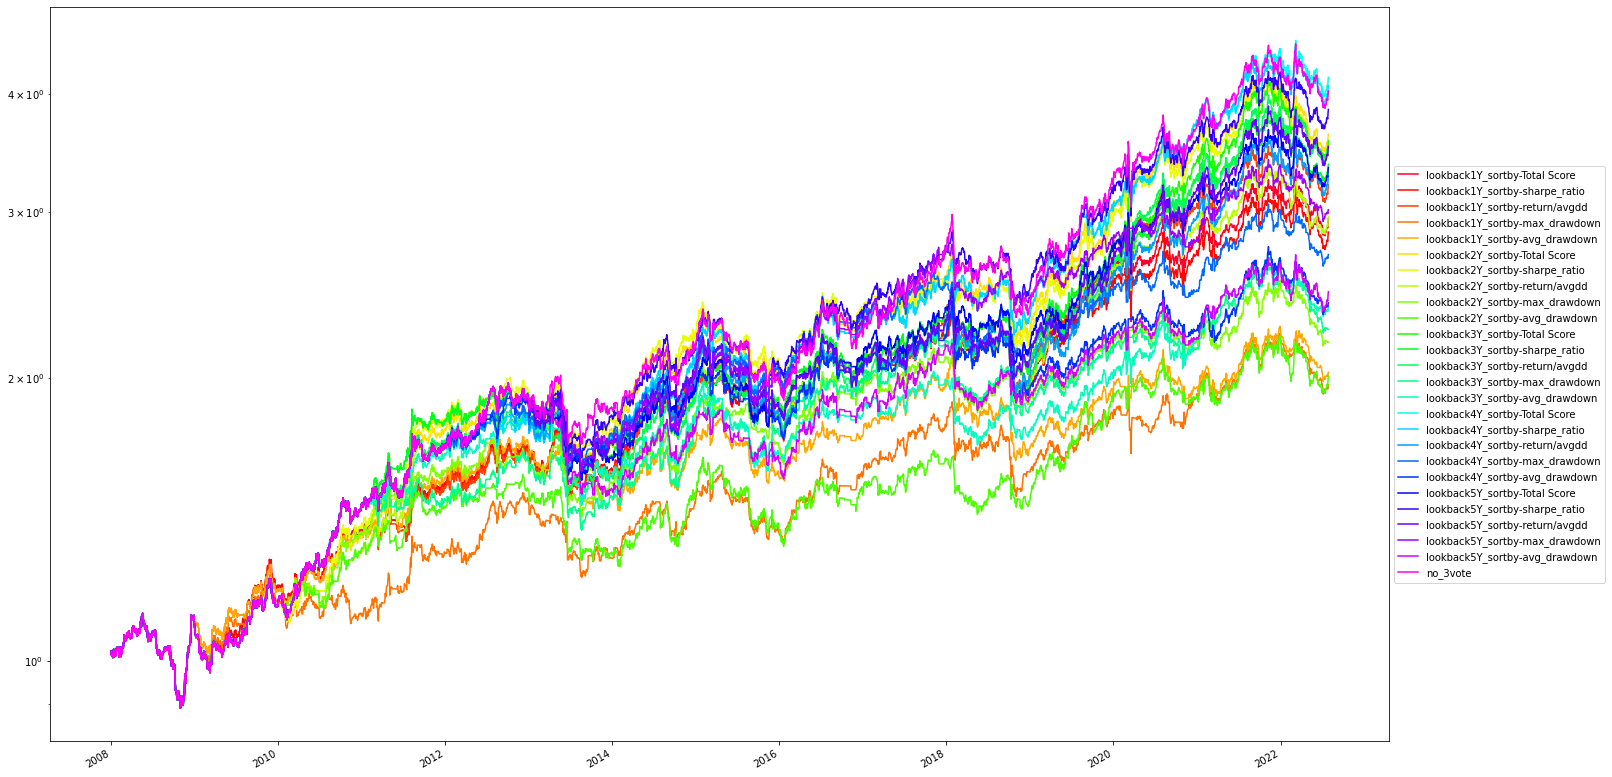

In [ ]:
met = empy_metric(slding_ret)
met = calculation_score(met)
met = met.sort_values('sharpe_ratio', ascending=False)
display(met)
show_cum_ret(slding_ret)

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       1.325395       0.092211      0.793471   
lookback4Y_sortby-sharpe_ratio      1.278396       0.089883      0.775634   
lookback5Y_sortby-sharpe_ratio      1.035135       0.077096      0.675003   
no_3vote                            1.129764       0.082225      0.658750   
lookback2Y_sortby-Total Score       0.936380       0.071511      0.634648   
lookback3Y_sortby-return/avgdd      0.945014       0.072009      0.628062   
lookback1Y_sortby-return/avgdd      0.935480       0.071459      0.627900   
lookback2Y_sortby-sharpe_ratio      0.852025       0.066534      0.599868   
lookback3Y_sortby-Total Score       0.877875       0.068080      0.598836   
lookback5Y_sortby-return/avgdd      0.860129       0.067021      0.583457   
lookback4Y_sortby-return/avgdd      0.814003       0.064224      0.558421   
lookback3Y_sortby-sharpe_ratio      0.774119       0.061754      0.552594   
lookback5Y_sortby-Total Score       0.765831       0.061235      0.548485   
lookback1Y_sortby-Total Score       0.766382       0.061269      0.547375   
lookback1Y_sortby-sharpe_ratio      0.708713       0.057594      0.517348   
lookback5Y_sortby-max_drawdown      0.592679       0.049849      0.492958   
lookback2Y_sortby-return/avgdd      0.639629       0.053041      0.477545   
lookback4Y_sortby-max_drawdown      0.476647       0.041581      0.430286   
lookback3Y_sortby-max_drawdown      0.382027       0.034396      0.369515   
lookback2Y_sortby-max_drawdown      0.341969       0.031221      0.338263   
lookback1Y_sortby-max_drawdown      0.336542       0.030784      0.328373   
lookback3Y_sortby-avg_drawdown      0.318995       0.029362      0.315121   
lookback2Y_sortby-avg_drawdown      0.321191       0.029541      0.309881   
lookback5Y_sortby-avg_drawdown      0.302972       0.028047      0.300938   
lookback4Y_sortby-avg_drawdown      0.290472       0.027012      0.290129   
lookback1Y_sortby-avg_drawdown      0.196623       0.018939      0.225278   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.120327     -0.167843     -0.048559   
lookback4Y_sortby-sharpe_ratio           0.120345     -0.167843     -0.048628   
lookback5Y_sortby-sharpe_ratio           0.120885     -0.167843     -0.051116   
no_3vote                                 0.133536     -0.222995     -0.063756   
lookback2Y_sortby-Total Score            0.120261     -0.204366     -0.059326   
lookback3Y_sortby-return/avgdd           0.122747     -0.205230     -0.060633   
lookback1Y_sortby-return/avgdd           0.121772     -0.221944     -0.060402   
lookback2Y_sortby-sharpe_ratio           0.119275     -0.204366     -0.060205   
lookback3Y_sortby-Total Score            0.122576     -0.205230     -0.066355   
lookback5Y_sortby-return/avgdd           0.124512     -0.199052     -0.065879   
lookback4Y_sortby-return/avgdd           0.125644     -0.204465     -0.059122   
lookback3Y_sortby-sharpe_ratio           0.121939     -0.205230     -0.064797   
lookback5Y_sortby-Total Score            0.121954     -0.180233     -0.058160   
lookback1Y_sortby-Total Score            0.122356     -0.204366     -0.055859   
lookback1Y_sortby-sharpe_ratio           0.122873     -0.204366     -0.055838   
lookback5Y_sortby-max_drawdown           0.111275     -0.173229     -0.056445   
lookback2Y_sortby-return/avgdd           0.124505     -0.235274     -0.064561   
lookback4Y_sortby-max_drawdown           0.108357     -0.190940     -0.064250   
lookback3Y_sortby-max_drawdown           0.107067     -0.185573     -0.060980   
lookback2Y_sortby-max_drawdown           0.108251     -0.164768     -0.054644   
lookback1Y_sortby-max_drawdown           0.111212     -0.206300     -0.063062   
lookback3Y_sortby-avg_drawdown           0.111661     -0.196759     -0.074476   
lookback2Y_sortby-avg_drawdown           0.115541     -0.195343     -0.071415   
lookback

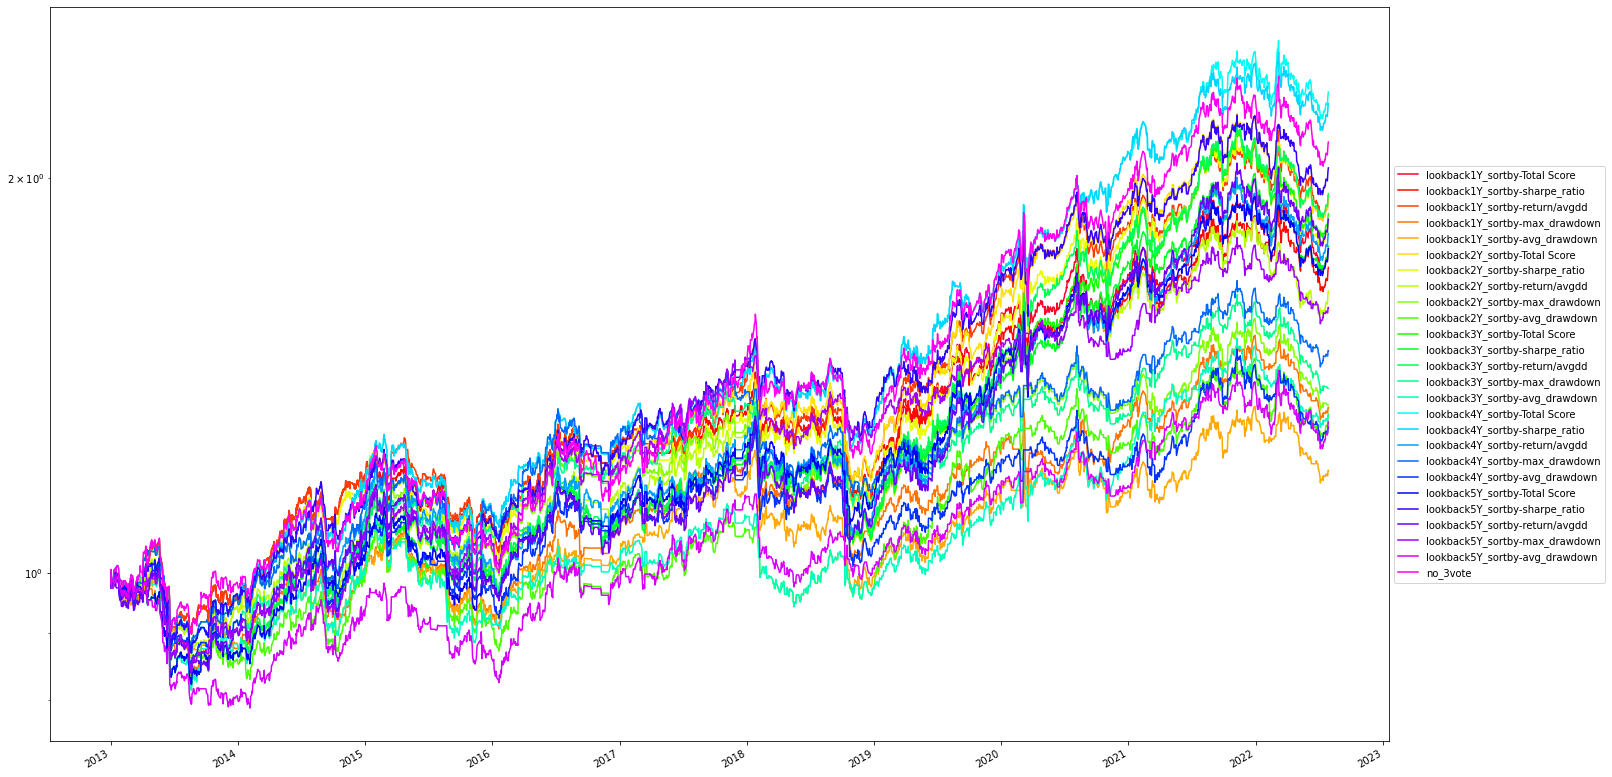

In [ ]:
slding_ret.index = pd.to_datetime(slding_ret.index)
slding_ret_13_22 = slding_ret['2013':]
met_13_22 = empy_metric(slding_ret_13_22)
met_13_22 = calculation_score(met_13_22)
met_13_22 = met_13_22.sort_values('sharpe_ratio', ascending=False)
display(met_13_22)
show_cum_ret(slding_ret_13_22)

In [ ]:
# extending apply to 1 year
extend_base = [1, 2, 3, 4, 5]
extending_ret = pd.DataFrame()
extending_choose_met = {}
for eb in extend_base:
    # print("====================== eb ========================= ", eb)
    for sortby in follow_metrics:
        # print("====================== sortby ========================= ", sortby)
        case_name = 'extending_base{}Y_sortby-{}'.format(eb, sortby)
        range_s = 2008 + eb
        start = 2008
        if eb == 1:
            ret_ser = ret_vote0['no_3vote'][str(start)]
        else:
            ret_ser = ret_vote0['no_3vote'][str(start):str(range_s-1)]
        choose_met = {}
        # print(ret_ser)
        for yy in range(range_s, 2023):
            # print("====================== for year ========================= ", yy)
            try:
                end = yy - 1
                # print(start, end, yy)

                if start == end:
                    file_name = '{}.csv'.format(start)
                else:
                    file_name = 'extending_{}-{}.csv'.format(start, end)
                # print("file_name: ", file_name)
                path = os.path.join(met_folder, file_name)
                met = pd.read_csv(path, index_col=0)
                met = met.sort_values(sortby, ascending=False)
                best_met = met.iloc[[0], :]
                choose_met[yy] = best_met
                # print(best_met.index[0])
                ret_yy = ret_vote0[best_met.index[0]][str(yy)]
            except Exception as e:
                print(e)
                ret_yy = ret_vote0['no_3vote'][str(yy)]
            # print(ret_yy)
            ret_ser = pd.concat([ret_ser, ret_yy])
        ret_ser.name = case_name
        extending_ret = pd.concat([extending_ret, ret_ser], axis=1)

        choose_met_df = pd.concat(choose_met.values(), keys=choose_met.keys())
        extending_choose_met[case_name] = choose_met_df
extending_ret.index = pd.to_datetime(extending_ret.index)


In [ ]:
extending_ret['no_3vote'] = ret_vote0['no_3vote']

total_return  annual_return  \
no_3vote                                  3.034788       0.100522   
extending_base1Y_sortby-sharpe_ratio      2.517910       0.090211   
extending_base5Y_sortby-return/avgdd      2.610569       0.092159   
extending_base3Y_sortby-return/avgdd      2.476071       0.089316   
extending_base3Y_sortby-sharpe_ratio      2.522049       0.090299   
extending_base5Y_sortby-sharpe_ratio      2.509149       0.090024   
extending_base4Y_sortby-return/avgdd      2.442281       0.088585   
extending_base2Y_sortby-sharpe_ratio      2.356775       0.086707   
extending_base1Y_sortby-return/avgdd      2.237039       0.084000   
extending_base4Y_sortby-sharpe_ratio      2.321782       0.085925   
extending_base5Y_sortby-max_drawdown      2.264412       0.084627   
extending_base2Y_sortby-return/avgdd      2.117838       0.081211   
extending_base4Y_sortby-max_drawdown      2.155487       0.082102   
extending_base3Y_sortby-Total Score       2.184208       0.082776   
extending_base1Y_sortby-Total Score       2.102073       0.080835   
extending_base5Y_sortby-Total Score       2.172545       0.082503   
extending_base2Y_sortby-Total Score       1.959985       0.077360   
extending_base4Y_sortby-Total Score       2.003150       0.078432   
extending_base3Y_sortby-max_drawdown      1.760628       0.072215   
extending_base5Y_sortby-avg_drawdown      1.703923       0.070688   
extending_base1Y_sortby-max_drawdown      1.622934       0.068454   
extending_base4Y_sortby-avg_drawdown      1.657509       0.069416   
extending_base3Y_sortby-avg_drawdown      1.597263       0.067733   
extending_base2Y_sortby-max_drawdown      1.588355       0.067481   
extending_base1Y_sortby-avg_drawdown      1.418662       0.062523   
extending_base2Y_sortby-avg_drawdown      1.329598       0.059789   

                                      sharpe_ratio  annual_volatility  \
no_3vote                                  0.789674           0.132437   
extending_base1Y_sortby-sharpe_ratio      0.761749           0.123413   
extending_base5Y_sortby-return/avgdd      0.761163           0.126333   
extending_base3Y_sortby-return/avgdd      0.756398           0.123157   
extending_base3Y_sortby-sharpe_ratio      0.755433           0.124775   
extending_base5Y_sortby-sharpe_ratio      0.743496           0.126780   
extending_base4Y_sortby-return/avgdd      0.738479           0.125659   
extending_base2Y_sortby-sharpe_ratio      0.734528           0.123640   
extending_base1Y_sortby-return/avgdd      0.730128           0.120431   
extending_base4Y_sortby-sharpe_ratio      0.716919           0.126103   
extending_base5Y_sortby-max_drawdown      0.712641           0.124983   
extending_base2Y_sortby-return/avgdd      0.704669           0.121269   
extending_base4Y_sortby-max_drawdown      0.699015           0.123890   
extending_base3Y_sortby-Total Score       0.697379           0.125330   
extending_base1Y_sortby-Total Score       0.688180           0.124191   
extending_base5Y_sortby-Total Score       0.686455           0.127326   
extending_base2Y_sortby-Total Score       0.661276           0.124416   
extending_base4Y_sortby-Total Score       0.659677           0.126651   
extending_base3Y_sortby-max_drawdown      0.632256           0.122102   
extending_base5Y_sortby-avg_drawdown      0.616101           0.123210   
extending_base1Y_sortby-max_drawdown      0.613036           0.119730   
extending_base4Y_sortby-avg_drawdown      0.610101           0.122286   
extending_base3Y_sortby-avg_drawdown      0.606539           0.119939   
extending_base2Y_sortby-max_drawdown      0.602780           0.120386   
extending_base1Y_sortby-avg_drawdown      0.576448           0.117134   
extending_base2Y_sortby-avg_drawdown      0.551267           0.117994   

                                      max_drawdown  avg_drawdown  \
no_3vote                                 -0.222995     -0.055768   
extending_base1Y_sortby-sharpe_ratio     -0.206512     -0.050846  

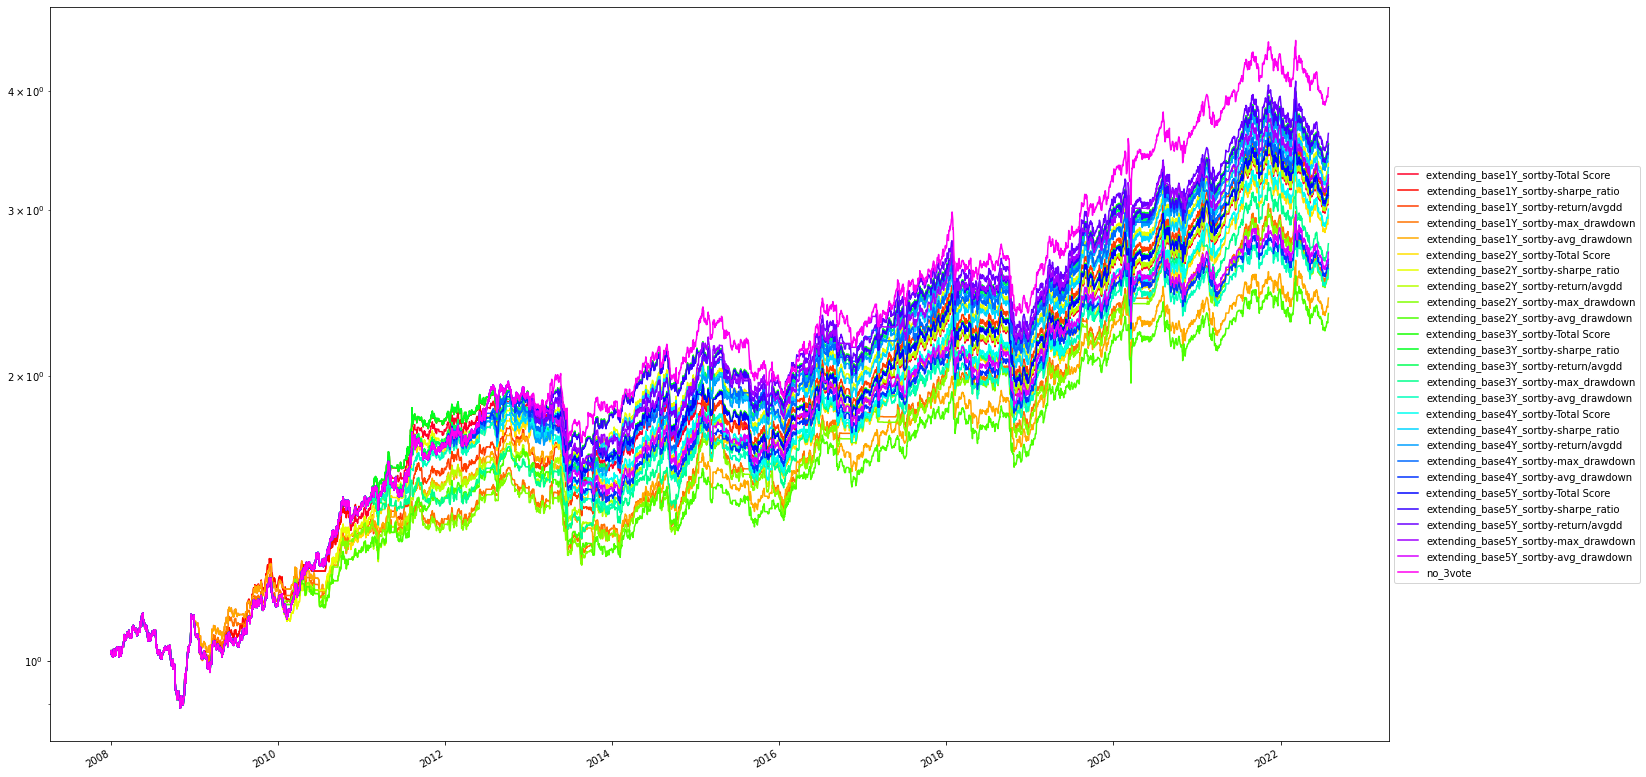

In [ ]:
met = empy_metric(extending_ret)
met = calculation_score(met)
met = met.sort_values('sharpe_ratio', ascending=False)
display(met)
show_cum_ret(extending_ret)

In [ ]:
extending_08_12 = extending_ret[:'2012']
extending_met_08_12 = empy_metric(extending_08_12)
extending_met_08_12 = calculation_score(extending_met_08_12)
extending_met_08_12_best = extending_met_08_12.sort_values('sharpe_ratio', ascending=False)#[:'no_3vote']
display(extending_met_08_12_best)
show_cum_ret(extending_08_12)

In [112]:
met_folder = './result/2022/cashON_signal/result/ret_corr_threshold_v6'
slding_ret_path = os.path.join(met_folder, 'ret_slding.csv')
extending_ret_path = os.path.join(met_folder, 'ret_extending.csv')

In [113]:
try:
    slding_ret = pd.read_csv(slding_ret_path, index_col=0)
    slding_ret.index = pd.to_datetime(slding_ret.index)
    extending_ret = pd.read_csv(extending_ret_path, index_col=0)
    extending_ret.index = pd.to_datetime(extending_ret.index)
except:
    slding_ret.to_csv(slding_ret_path)
    extending_ret.to_csv(extending_ret_path)

In [114]:
extending_ret = extending_ret.loc[:, extending_ret.columns != 'no_3vote']
ret_cases = pd.concat([slding_ret, extending_ret], axis=1).dropna()

In [115]:
ret_cases

lookback1Y_sortby-Total Score  lookback1Y_sortby-sharpe_ratio  \
2008-01-02                       0.021031                        0.021031   
2008-01-03                       0.004646                        0.004646   
2008-01-04                      -0.008659                       -0.008659   
2008-01-07                      -0.003824                       -0.003824   
2008-01-08                       0.002096                        0.002096   
...                                   ...                             ...   
2022-07-25                      -0.000582                       -0.000582   
2022-07-26                      -0.002362                       -0.002362   
2022-07-27                       0.009400                        0.009400   
2022-07-28                       0.009597                        0.009597   
2022-07-29                       0.003906                        0.003906   

            lookback1Y_sortby-return/avgdd  lookback1Y_sortby-max_drawdown  \
2008-01-02                        0.021031                        0.021031   
2008-01-03                        0.004646                        0.004646   
2008-01-04                       -0.008659                       -0.008659   
2008-01-07                       -0.003824                       -0.003824   
2008-01-08                        0.002096                        0.002096   
...                                    ...                             ...   
2022-07-25                        0.000000                       -0.000582   
2022-07-26                        0.000000                       -0.000100   
2022-07-27                        0.009299                        0.000000   
2022-07-28                        0.009597                        0.000000   
2022-07-29                        0.003906                        0.003804   

            lookback1Y_sortby-avg_drawdown  lookback2Y_sortby-Total Score  \
2008-01-02                        0.021031                       0.021031   
2008-01-03                        0.004646                       0.004646   
2008-01-04                       -0.008659                      -0.008659   
2008-01-07                       -0.003824                      -0.003824   
2008-01-08                        0.002096                       0.002096   
...                                    ...                            ...   
2022-07-25                        0.000000                      -0.000582   
2022-07-26                        0.000000                      -0.002362   
2022-07-27                        0.009299                       0.009400   
2022-07-28                       -0.000101                       0.009597   
2022-07-29                        0.003802                       0.003906   

            lookback2Y_sortby-sharpe_ratio  lookback2Y_sortby-return/avgdd  \
2008-01-02                        0.021031                        0.021031   
2008-01-03                        0.004646                        0.004646   
2008-01-04                       -0.008659                       -0.008659   
2008-01-07                       -0.003824                       -0.003824   
2008-01-08                        0.002096                        0.002096   
...                                    ...                             ...   
2022-07-25                       -0.000582                       -0.000582   
2022-07-26                       -0.002362                       -0.002362   
2022-07-27                        0.009400                        0.009400   
2022-07-28                        0.009597                        0.009597   
2022-07-29                        0.003906                        0.003906   

            lookback2Y_sortby-max_drawdown  lookback2Y_sortby-avg_drawdown  \
2008-01-02                        0.021031                        0.021031   
2008-01-03                        0.004646                        0.004646   
2008-01-04                       -0.008659            

total_return  annual_return  sharpe_ratio  annual_volatility  \
no_3vote      3.034788       0.100522      0.789674           0.132437   

          max_drawdown  avg_drawdown  return/maxdd  return/avgdd  buy_ratio  \
no_3vote     -0.222995     -0.055768      0.450779      1.802511        1.0   

          flip_ratio  Sharpe Score  Return Score  Max-DD Score  Total Score  
no_3vote         0.0     78.967389    105.026082      77.70045        3.336

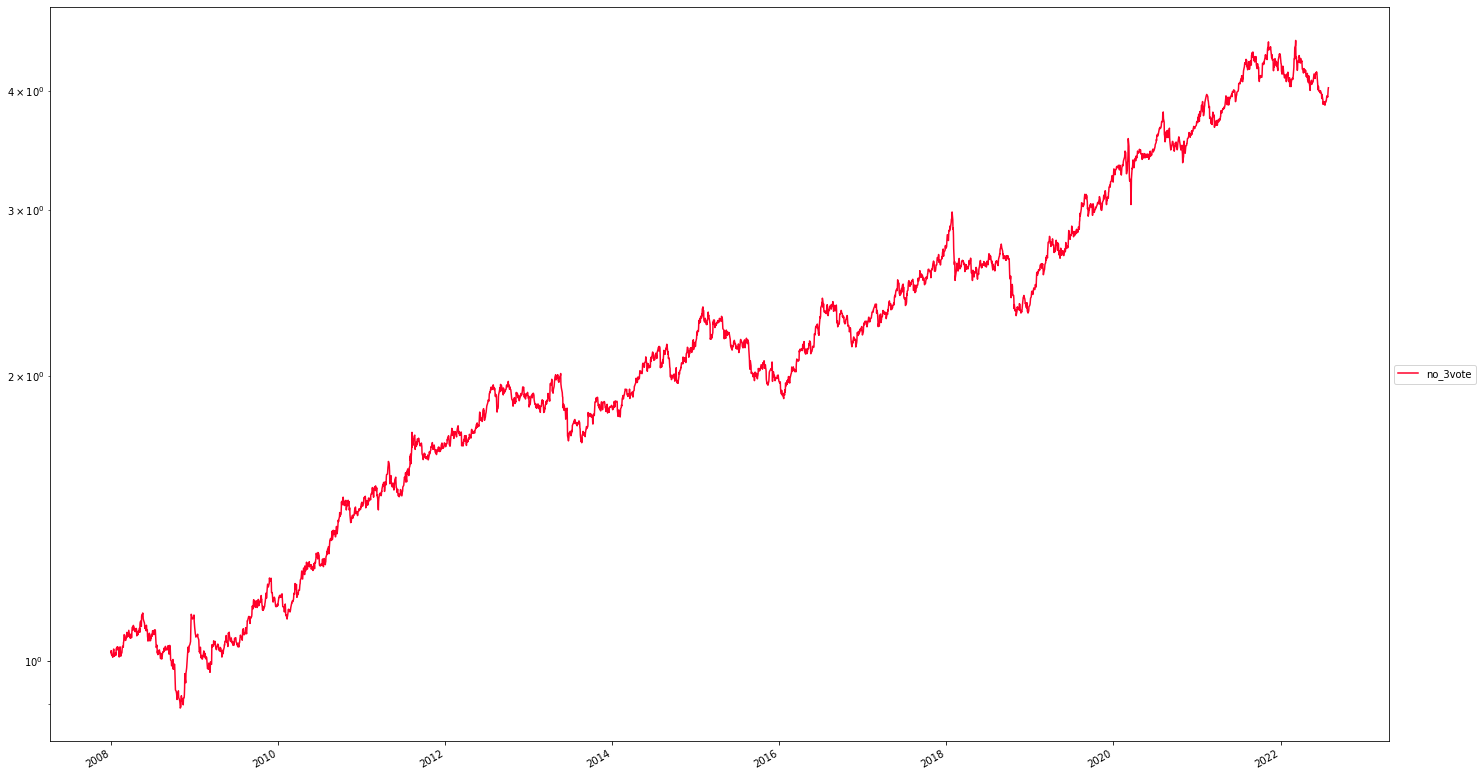

In [117]:
# EEM, TLT, GLD

met_08_22 = empy_metric(ret_cases)
met_08_22 = calculation_score(met_08_22)
met_08_22_best = met_08_22.sort_values('sharpe_ratio', ascending=False)[:'no_3vote']
display(met_08_22_best)
show_cum_ret(ret_cases[met_08_22_best.index])

In [ ]:
ret_cases_08_12 = ret_cases[:'2012']
met_08_12 = empy_metric(ret_cases_08_12)
met_08_12 = calculation_score(met_08_12)
met_08_12_best = met_08_12.sort_values('sharpe_ratio', ascending=False)#[:'no_3vote']
display(met_08_12_best)
show_cum_ret(ret_cases_08_12)

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       1.325395       0.092211      0.793471   
lookback4Y_sortby-sharpe_ratio      1.278396       0.089883      0.775634   
lookback5Y_sortby-sharpe_ratio      1.035135       0.077096      0.675003   
no_3vote                            1.129764       0.082225      0.658750   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.120327     -0.167843     -0.048559   
lookback4Y_sortby-sharpe_ratio           0.120345     -0.167843     -0.048628   
lookback5Y_sortby-sharpe_ratio           0.120885     -0.167843     -0.051116   
no_3vote                                 0.133536     -0.222995     -0.063756   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score       0.549388      1.898958   0.947325   
lookback4Y_sortby-sharpe_ratio      0.535516      1.848377   0.947740   
lookback5Y_sortby-sharpe_ratio      0.459334      1.508255   0.963501   
no_3vote                            0.368729      1.289684   1.000000   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score     0.044813     79.347121    104.610555   
lookback4Y_sortby-sharpe_ratio    0.043983     77.563414    104.494133   
lookback5Y_sortby-sharpe_ratio    0.040664     67.500293    103.854805   
no_3vote                          0.000000     65.874973    104.111245   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      83.215677     3.589195  
lookback4Y_sortby-sharpe_ratio     83.215677     3.488368  
lookback5Y_sortby-sharpe_ratio     83.215677     2.921279  
no_3vote                           77.700450     2.589896

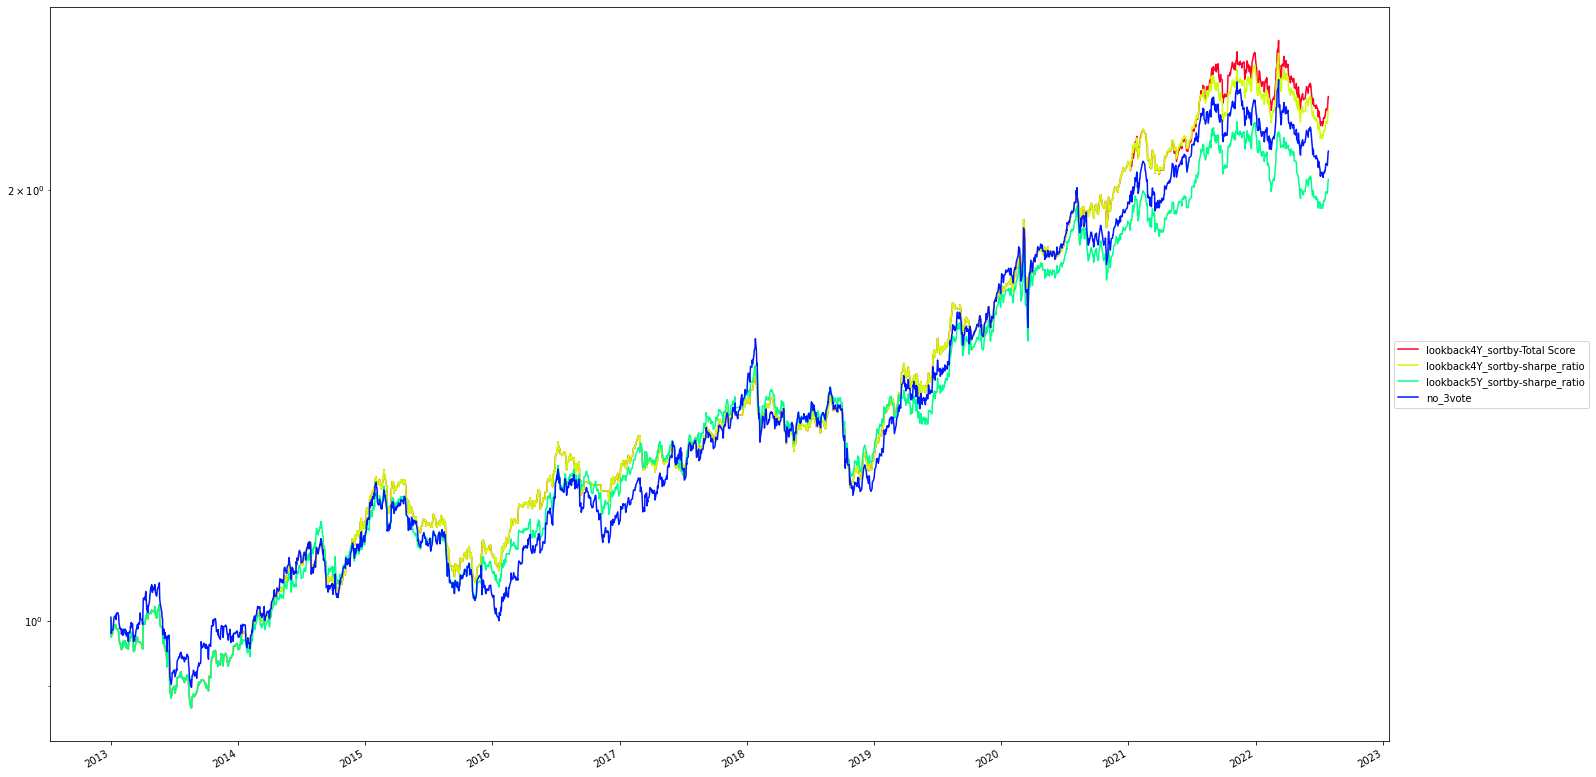

In [105]:
ret_cases_13_22 = ret_cases['2013':]
met_13_22 = empy_metric(ret_cases_13_22)
met_13_22 = calculation_score(met_13_22)
met_13_22_best = met_13_22.sort_values('sharpe_ratio', ascending=False)[:'no_3vote']
display(met_13_22_best)

show_cum_ret(ret_cases_13_22[met_13_22_best.index])

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       0.101795       0.101373      0.743047   
lookback4Y_sortby-sharpe_ratio      0.101795       0.101373      0.743047   
lookback5Y_sortby-sharpe_ratio      0.101795       0.101373      0.743047   
lookback2Y_sortby-Total Score       0.101795       0.101373      0.743047   
no_3vote                            0.101795       0.101373      0.743047   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.143785     -0.206512     -0.061791   
lookback4Y_sortby-sharpe_ratio           0.143785     -0.206512     -0.061791   
lookback5Y_sortby-sharpe_ratio           0.143785     -0.206512     -0.061791   
lookback2Y_sortby-Total Score            0.143785     -0.206512     -0.061791   
no_3vote                                 0.143785     -0.206512     -0.061791   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score       0.490884      1.640588        1.0   
lookback4Y_sortby-sharpe_ratio      0.490884      1.640588        1.0   
lookback5Y_sortby-sharpe_ratio      0.490884      1.640588        1.0   
lookback2Y_sortby-Total Score       0.490884      1.640588        1.0   
no_3vote                            0.490884      1.640588        1.0   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score          0.0      74.30471    105.068663   
lookback4Y_sortby-sharpe_ratio         0.0      74.30471    105.068663   
lookback5Y_sortby-sharpe_ratio         0.0      74.30471    105.068663   
lookback2Y_sortby-Total Score          0.0      74.30471    105.068663   
no_3vote                               0.0      74.30471    105.068663   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      79.348844     3.189544  
lookback4Y_sortby-sharpe_ratio     79.348844     3.189544  
lookback5Y_sortby-sharpe_ratio     79.348844     3.189544  
lookback2Y_sortby-Total Score      79.348844     3.189544  
no_3vote                           79.348844     3.189544

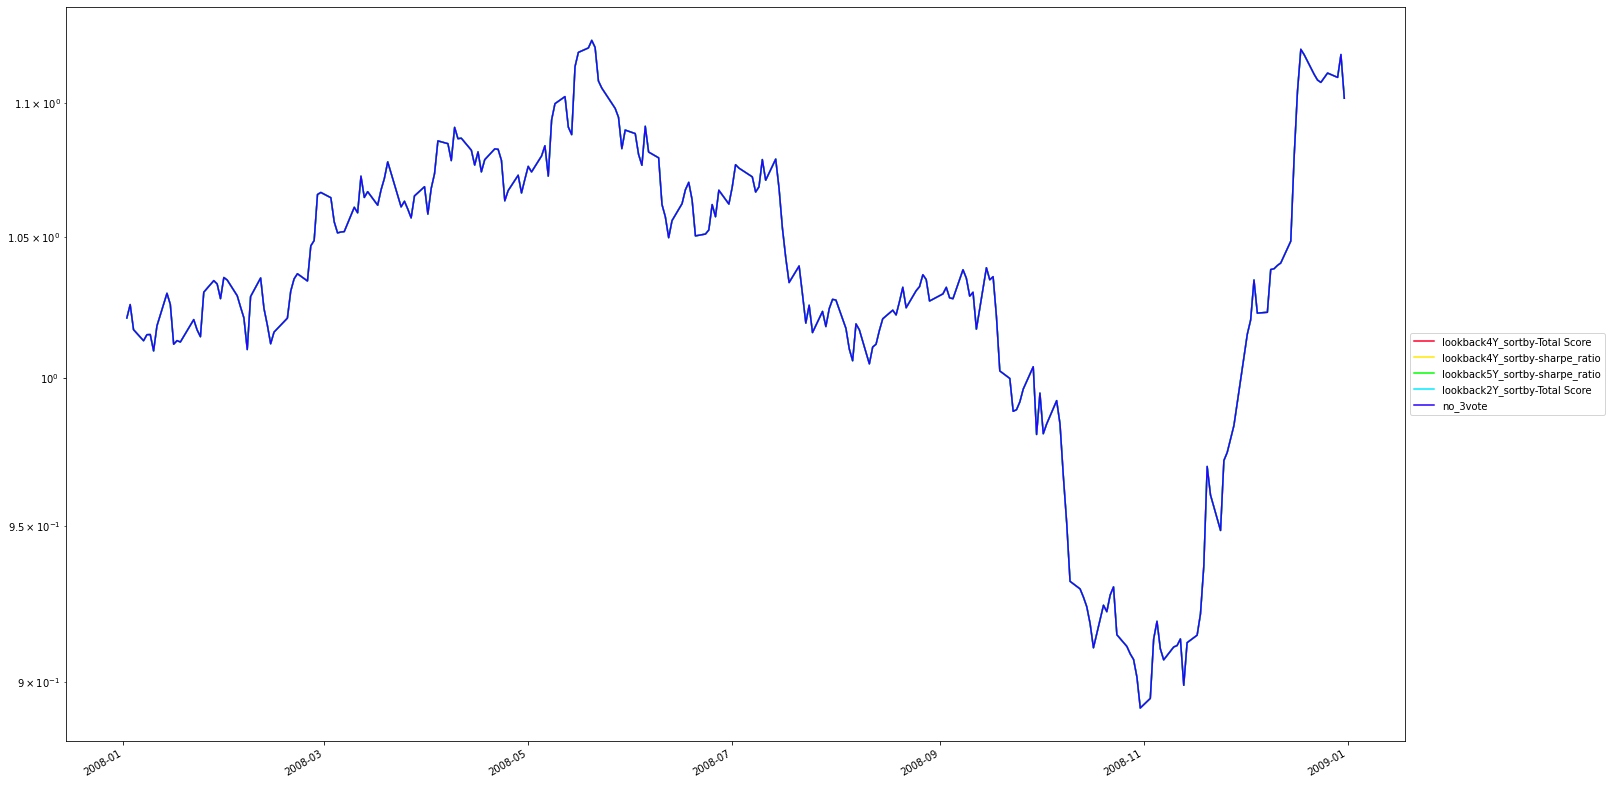

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       0.038214       0.038214       0.35987   
lookback4Y_sortby-sharpe_ratio      0.038214       0.038214       0.35987   
lookback5Y_sortby-sharpe_ratio      0.038214       0.038214       0.35987   
lookback2Y_sortby-Total Score       0.038214       0.038214       0.35987   
no_3vote                            0.038214       0.038214       0.35987   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score             0.12615     -0.116938     -0.042801   
lookback4Y_sortby-sharpe_ratio            0.12615     -0.116938     -0.042801   
lookback5Y_sortby-sharpe_ratio            0.12615     -0.116938     -0.042801   
lookback2Y_sortby-Total Score             0.12615     -0.116938     -0.042801   
no_3vote                                  0.12615     -0.116938     -0.042801   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score       0.326787      0.892826        1.0   
lookback4Y_sortby-sharpe_ratio      0.326787      0.892826        1.0   
lookback5Y_sortby-sharpe_ratio      0.326787      0.892826        1.0   
lookback2Y_sortby-Total Score       0.326787      0.892826        1.0   
no_3vote                            0.326787      0.892826        1.0   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score          0.0      35.98699    101.910697   
lookback4Y_sortby-sharpe_ratio         0.0      35.98699    101.910697   
lookback5Y_sortby-sharpe_ratio         0.0      35.98699    101.910697   
lookback2Y_sortby-Total Score          0.0      35.98699    101.910697   
no_3vote                               0.0      35.98699    101.910697   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      88.306177     1.405728  
lookback4Y_sortby-sharpe_ratio     88.306177     1.405728  
lookback5Y_sortby-sharpe_ratio     88.306177     1.405728  
lookback2Y_sortby-Total Score      88.306177     1.405728  
no_3vote                           88.306177     1.405728

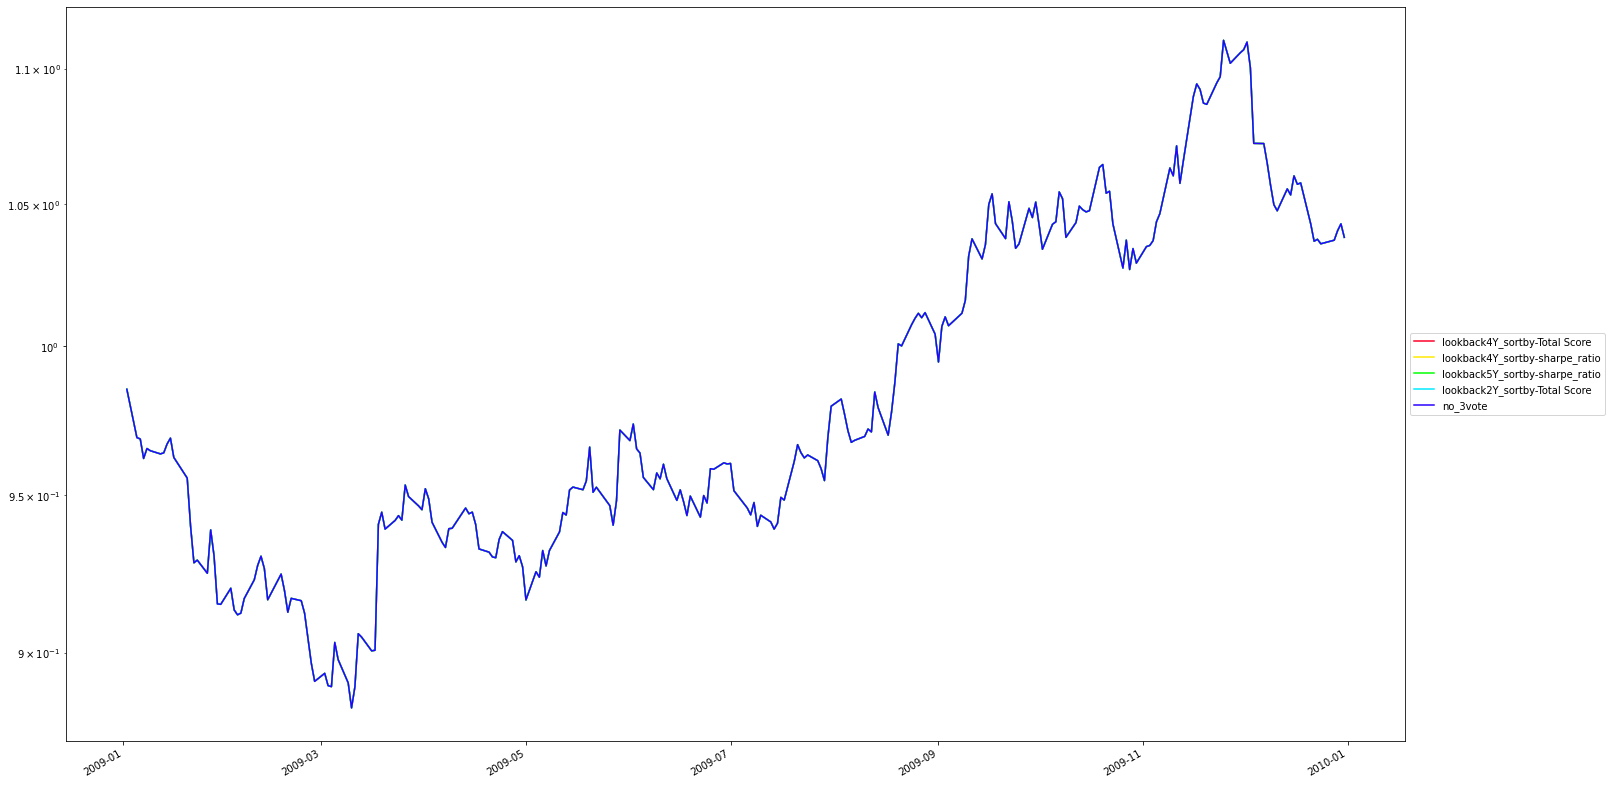

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       0.281022       0.281022       2.02792   
lookback4Y_sortby-sharpe_ratio      0.281022       0.281022       2.02792   
lookback5Y_sortby-sharpe_ratio      0.281022       0.281022       2.02792   
no_3vote                            0.281022       0.281022       2.02792   
lookback2Y_sortby-Total Score       0.190816       0.190816       1.60989   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.126092     -0.060037     -0.017061   
lookback4Y_sortby-sharpe_ratio           0.126092     -0.060037     -0.017061   
lookback5Y_sortby-sharpe_ratio           0.126092     -0.060037     -0.017061   
no_3vote                                 0.126092     -0.060037     -0.017061   
lookback2Y_sortby-Total Score            0.112431     -0.061176     -0.020082   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score       4.680823     16.471299    1.00000   
lookback4Y_sortby-sharpe_ratio      4.680823     16.471299    1.00000   
lookback5Y_sortby-sharpe_ratio      4.680823     16.471299    1.00000   
no_3vote                            4.680823     16.471299    1.00000   
lookback2Y_sortby-Total Score       3.119149      9.501957    0.84127   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score     0.000000    202.792013    114.051113   
lookback4Y_sortby-sharpe_ratio    0.000000    202.792013    114.051113   
lookback5Y_sortby-sharpe_ratio    0.000000    202.792013    114.051113   
no_3vote                          0.000000    202.792013    114.051113   
lookback2Y_sortby-Total Score     0.007968    160.989015    109.540817   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      93.996307    11.244527  
lookback4Y_sortby-sharpe_ratio     93.996307    11.244527  
lookback5Y_sortby-sharpe_ratio     93.996307    11.244527  
no_3vote                           93.996307    11.244527  
lookback2Y_sortby-Total Score      93.882423     8.697654

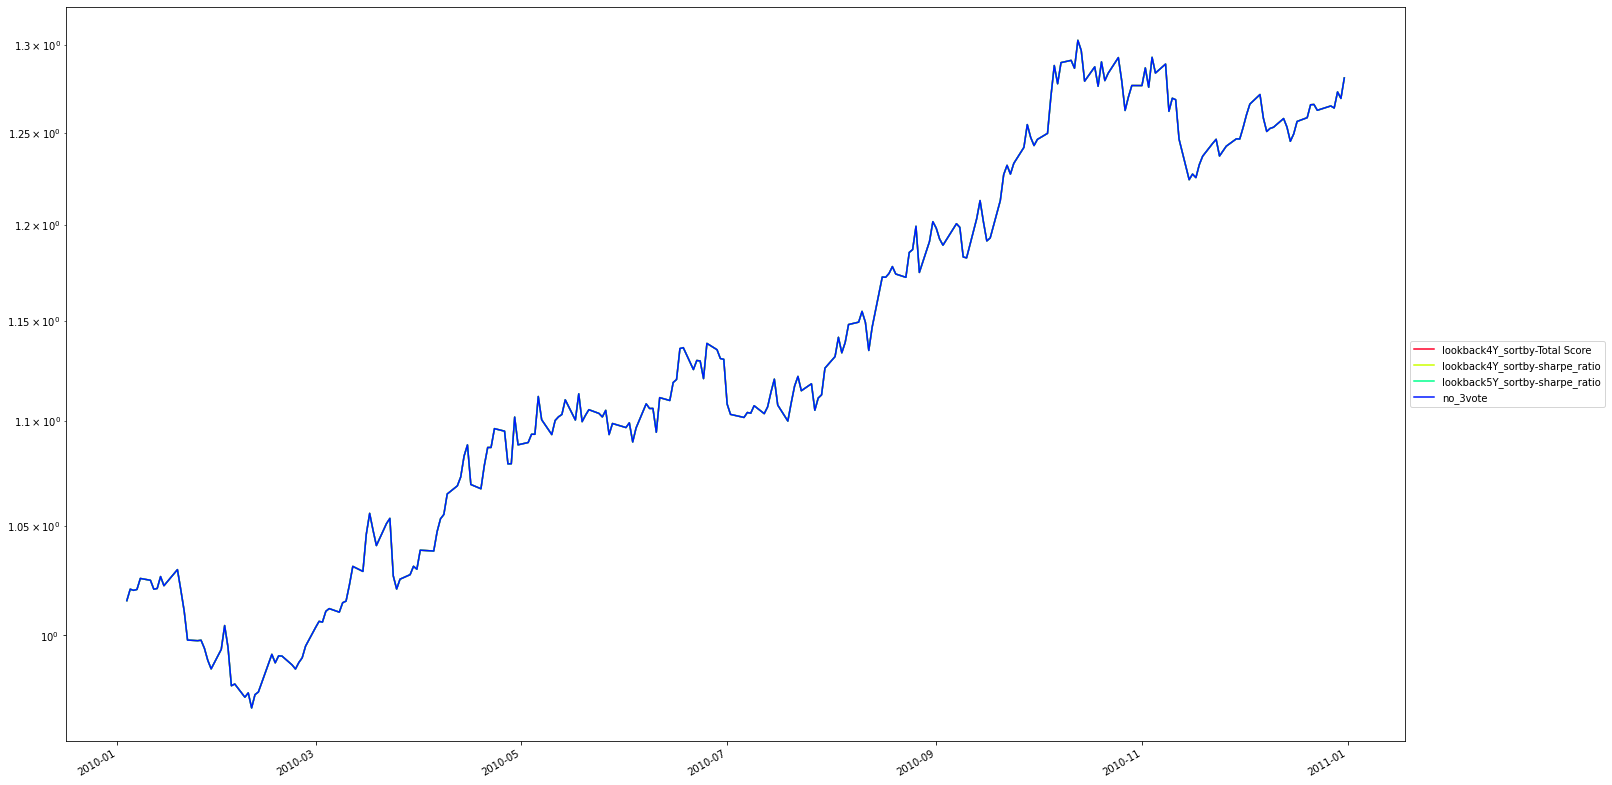

total_return  annual_return  sharpe_ratio  \
lookback2Y_sortby-Total Score       0.295893       0.295893      2.107153   
lookback4Y_sortby-Total Score       0.160452       0.160452      1.130731   
lookback4Y_sortby-sharpe_ratio      0.160452       0.160452      1.130731   
lookback5Y_sortby-sharpe_ratio      0.160452       0.160452      1.130731   
no_3vote                            0.160452       0.160452      1.130731   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback2Y_sortby-Total Score            0.126877     -0.056665     -0.016315   
lookback4Y_sortby-Total Score            0.140327     -0.082386     -0.031619   
lookback4Y_sortby-sharpe_ratio           0.140327     -0.082386     -0.031619   
lookback5Y_sortby-sharpe_ratio           0.140327     -0.082386     -0.031619   
no_3vote                                 0.140327     -0.082386     -0.031619   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback2Y_sortby-Total Score       5.221836     18.136314    0.93254   
lookback4Y_sortby-Total Score       1.947571      5.074507    1.00000   
lookback4Y_sortby-sharpe_ratio      1.947571      5.074507    1.00000   
lookback5Y_sortby-sharpe_ratio      1.947571      5.074507    1.00000   
no_3vote                            1.947571      5.074507    1.00000   

                                flip_ratio  Sharpe Score  Return Score  \
lookback2Y_sortby-Total Score     0.039841    210.715283    114.794673   
lookback4Y_sortby-Total Score     0.000000    113.073136    108.022615   
lookback4Y_sortby-sharpe_ratio    0.000000    113.073136    108.022615   
lookback5Y_sortby-sharpe_ratio    0.000000    113.073136    108.022615   
no_3vote                          0.000000    113.073136    108.022615   

                                Max-DD Score  Total Score  
lookback2Y_sortby-Total Score      94.333536    11.731908  
lookback4Y_sortby-Total Score      91.761417     6.043989  
lookback4Y_sortby-sharpe_ratio     91.761417     6.043989  
lookback5Y_sortby-sharpe_ratio     91.761417     6.043989  
no_3vote                           91.761417     6.043989

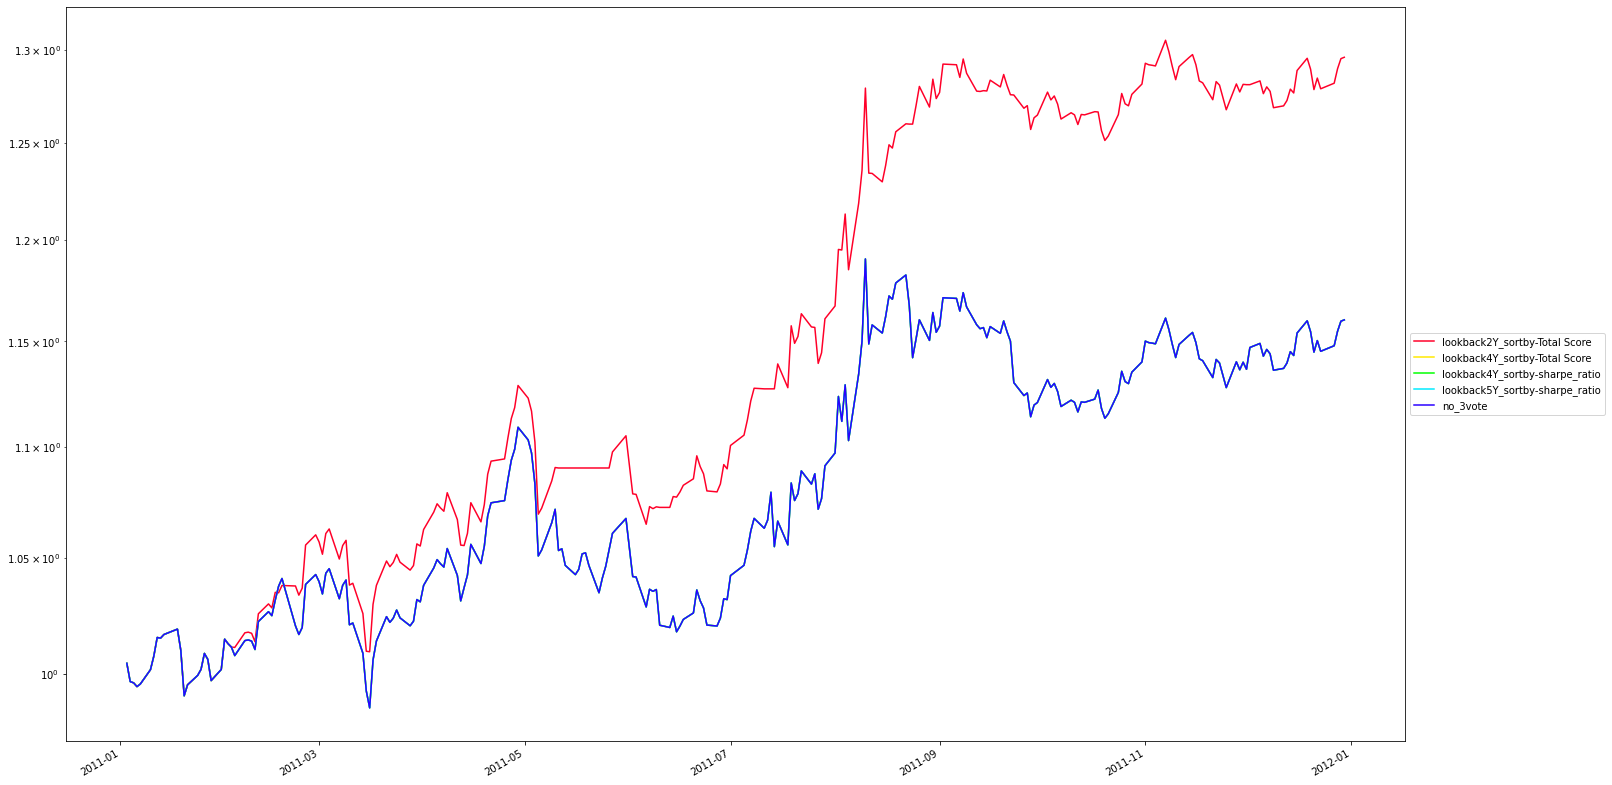

total_return  annual_return  sharpe_ratio  \
lookback5Y_sortby-sharpe_ratio      0.114083       0.115046      1.016106   
no_3vote                            0.114083       0.115046      1.016106   
lookback2Y_sortby-Total Score       0.062155       0.062668      0.647425   
lookback4Y_sortby-Total Score       0.054597       0.055046      0.577225   
lookback4Y_sortby-sharpe_ratio      0.054597       0.055046      0.577225   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback5Y_sortby-sharpe_ratio           0.113513     -0.064203     -0.019268   
no_3vote                                 0.113513     -0.064203     -0.019268   
lookback2Y_sortby-Total Score            0.101888     -0.057735     -0.019599   
lookback4Y_sortby-Total Score            0.101793     -0.070449     -0.018607   
lookback4Y_sortby-sharpe_ratio           0.101793     -0.070449     -0.018607   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback5Y_sortby-sharpe_ratio      1.791917      5.970933      1.000   
no_3vote                            1.791917      5.970933      1.000   
lookback2Y_sortby-Total Score       1.085451      3.197548      0.928   
lookback4Y_sortby-Total Score       0.781364      2.958378      0.924   
lookback4Y_sortby-sharpe_ratio      0.781364      2.958378      0.924   

                                flip_ratio  Sharpe Score  Return Score  \
lookback5Y_sortby-sharpe_ratio    0.000000    101.610570    105.752296   
no_3vote                          0.000000    101.610570    105.752296   
lookback2Y_sortby-Total Score     0.032129     64.742523    103.133398   
lookback4Y_sortby-Total Score     0.032129     57.722518    102.752303   
lookback4Y_sortby-sharpe_ratio    0.032129     57.722518    102.752303   

                                Max-DD Score  Total Score  
lookback5Y_sortby-sharpe_ratio     93.579729     5.334745  
no_3vote                           93.579729     5.334745  
lookback2Y_sortby-Total Score      94.226550     3.261793  
lookback4Y_sortby-Total Score      92.955137     2.809113  
lookback4Y_sortby-sharpe_ratio     92.955137     2.809113

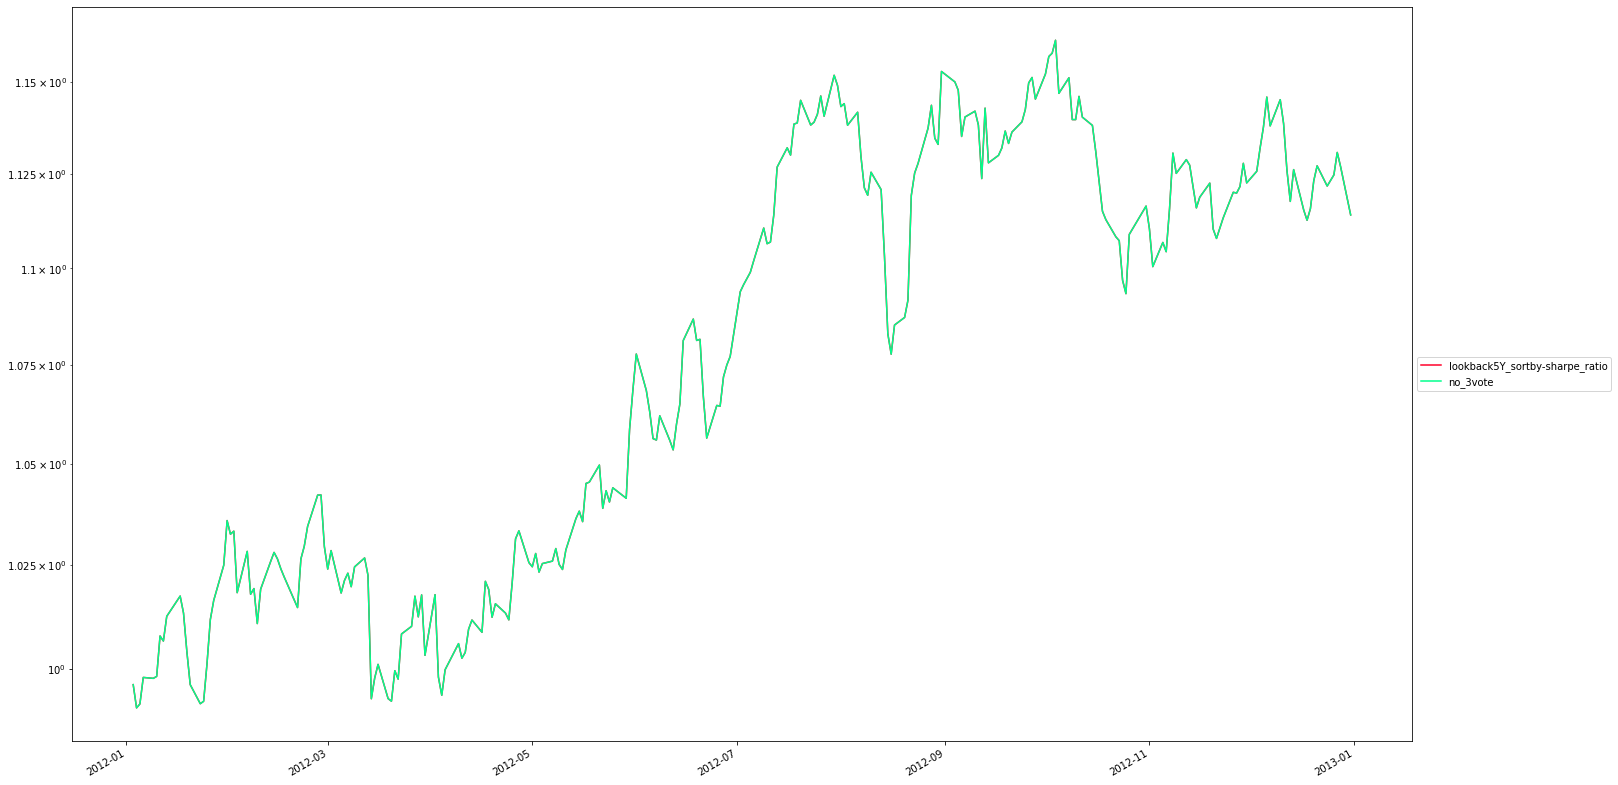

total_return  annual_return  sharpe_ratio  \
no_3vote                           -0.018283      -0.018283     -0.070520   
lookback4Y_sortby-Total Score      -0.037388      -0.037388     -0.266791   
lookback4Y_sortby-sharpe_ratio     -0.037388      -0.037388     -0.266791   
lookback5Y_sortby-sharpe_ratio     -0.037388      -0.037388     -0.266791   
lookback2Y_sortby-Total Score      -0.059011      -0.059011     -0.460694   

                                annual_volatility  max_drawdown  avg_drawdown  \
no_3vote                                 0.134133     -0.155032     -0.067167   
lookback4Y_sortby-Total Score            0.117098     -0.153285     -0.069342   
lookback4Y_sortby-sharpe_ratio           0.117098     -0.153285     -0.069342   
lookback5Y_sortby-sharpe_ratio           0.117098     -0.153285     -0.069342   
lookback2Y_sortby-Total Score            0.117104     -0.161650     -0.078662   

                                return/maxdd  return/avgdd  buy_ratio  \
no_3vote                           -0.117931     -0.272205   1.000000   
lookback4Y_sortby-Total Score      -0.243909     -0.539174   0.908730   
lookback4Y_sortby-sharpe_ratio     -0.243909     -0.539174   0.908730   
lookback5Y_sortby-sharpe_ratio     -0.243909     -0.539174   0.908730   
lookback2Y_sortby-Total Score      -0.365053     -0.750181   0.972222   

                                flip_ratio  Sharpe Score  Return Score  \
no_3vote                          0.000000             0     99.085843   
lookback4Y_sortby-Total Score     0.071713             0     98.130619   
lookback4Y_sortby-sharpe_ratio    0.071713             0     98.130619   
lookback5Y_sortby-sharpe_ratio    0.071713             0     98.130619   
lookback2Y_sortby-Total Score     0.047809             0     97.049467   

                                Max-DD Score  Total Score  
no_3vote                           84.496779    -1.219179  
lookback4Y_sortby-Total Score      84.671506    -2.287318  
lookback4Y_sortby-sharpe_ratio     84.671506    -2.287318  
lookback5Y_sortby-sharpe_ratio     84.671506    -2.287318  
lookback2Y_sortby-Total Score      83.835025    -3.406774

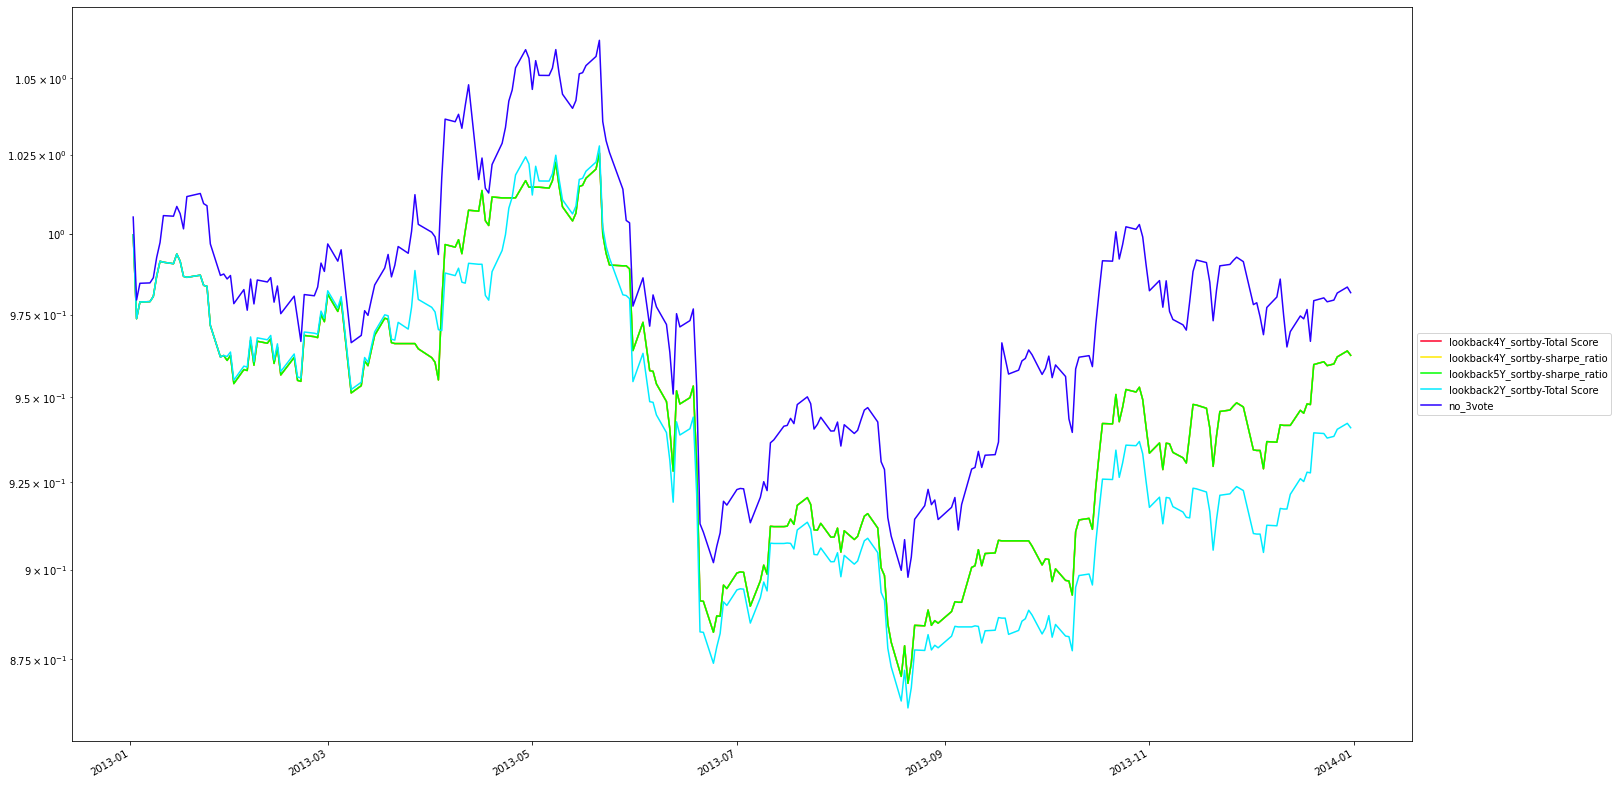

total_return  annual_return  sharpe_ratio  \
lookback2Y_sortby-Total Score       0.224423       0.224423      1.883840   
lookback4Y_sortby-Total Score       0.204637       0.204637      1.678394   
lookback4Y_sortby-sharpe_ratio      0.204637       0.204637      1.678394   
lookback5Y_sortby-sharpe_ratio      0.173349       0.173349      1.460077   
no_3vote                            0.155898       0.155898      1.222664   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback2Y_sortby-Total Score            0.110769     -0.065746     -0.015053   
lookback4Y_sortby-Total Score            0.114894     -0.081358     -0.018297   
lookback4Y_sortby-sharpe_ratio           0.114894     -0.081358     -0.018297   
lookback5Y_sortby-sharpe_ratio           0.113960     -0.096197     -0.025689   
no_3vote                                 0.124901     -0.090590     -0.022677   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback2Y_sortby-Total Score       3.413471     14.908824   0.948413   
lookback4Y_sortby-Total Score       2.515257     11.184483   0.980159   
lookback4Y_sortby-sharpe_ratio      2.515257     11.184483   0.980159   
lookback5Y_sortby-sharpe_ratio      1.802026      6.747999   0.976190   
no_3vote                            1.720922      6.874749   1.000000   

                                flip_ratio  Sharpe Score  Return Score  \
lookback2Y_sortby-Total Score     0.023904    188.384043    111.221128   
lookback4Y_sortby-Total Score     0.031873    167.839419    110.231858   
lookback4Y_sortby-sharpe_ratio    0.031873    167.839419    110.231858   
lookback5Y_sortby-sharpe_ratio    0.023904    146.007724    108.667463   
no_3vote                          0.000000    122.266427    107.794922   

                                Max-DD Score  Total Score  
lookback2Y_sortby-Total Score      93.425384    10.212584  
lookback4Y_sortby-Total Score      91.864165     9.008365  
lookback4Y_sortby-sharpe_ratio     91.864165     9.008365  
lookback5Y_sortby-sharpe_ratio     90.380312     7.686148  
no_3vote                           90.940994     6.439863

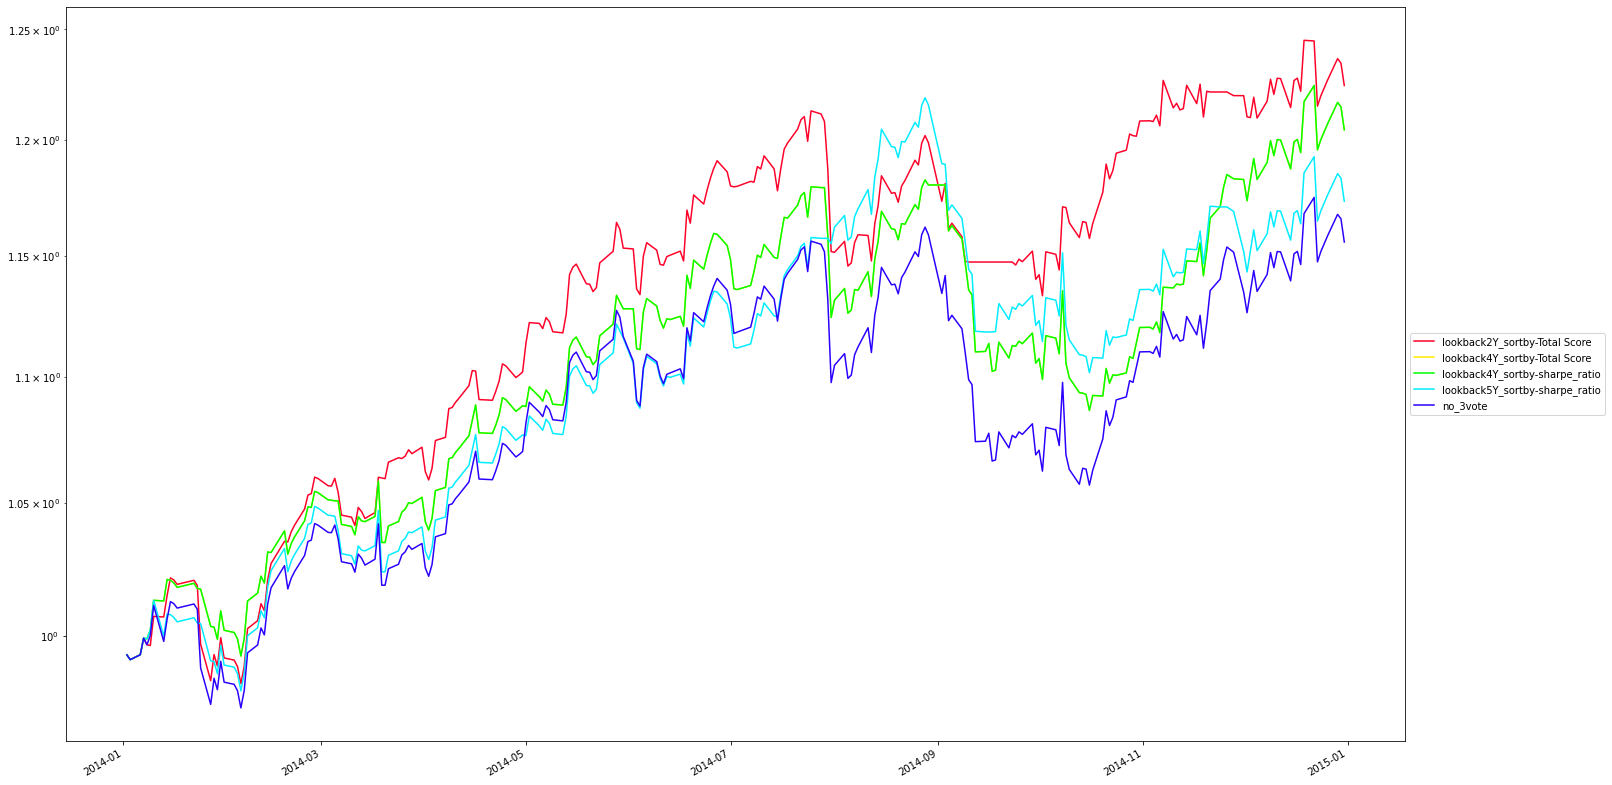

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score      -0.040313      -0.040313     -0.290673   
lookback4Y_sortby-sharpe_ratio     -0.040313      -0.040313     -0.290673   
lookback5Y_sortby-sharpe_ratio     -0.040313      -0.040313     -0.290673   
lookback2Y_sortby-Total Score      -0.066870      -0.066870     -0.570891   
no_3vote                           -0.080859      -0.080859     -0.578398   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.117748     -0.165797     -0.079429   
lookback4Y_sortby-sharpe_ratio           0.117748     -0.165797     -0.079429   
lookback5Y_sortby-sharpe_ratio           0.117748     -0.165797     -0.079429   
lookback2Y_sortby-Total Score            0.110518     -0.158581     -0.090878   
no_3vote                                 0.130934     -0.173532     -0.088168   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score      -0.243146     -0.507532   0.972222   
lookback4Y_sortby-sharpe_ratio     -0.243146     -0.507532   0.972222   
lookback5Y_sortby-sharpe_ratio     -0.243146     -0.507532   0.972222   
lookback2Y_sortby-Total Score      -0.421679     -0.735827   0.904762   
no_3vote                           -0.465958     -0.917101   1.000000   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score     0.039841             0     97.984359   
lookback4Y_sortby-sharpe_ratio    0.039841             0     97.984359   
lookback5Y_sortby-sharpe_ratio    0.039841             0     97.984359   
lookback2Y_sortby-Total Score     0.087649             0     96.656482   
no_3vote                          0.000000             0     95.957056   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      83.420293    -2.483914  
lookback4Y_sortby-sharpe_ratio     83.420293    -2.483914  
lookback5Y_sortby-sharpe_ratio     83.420293    -2.483914  
lookback2Y_sortby-Total Score      84.141868    -3.981712  
no_3vote                           82.646754    -4.163946

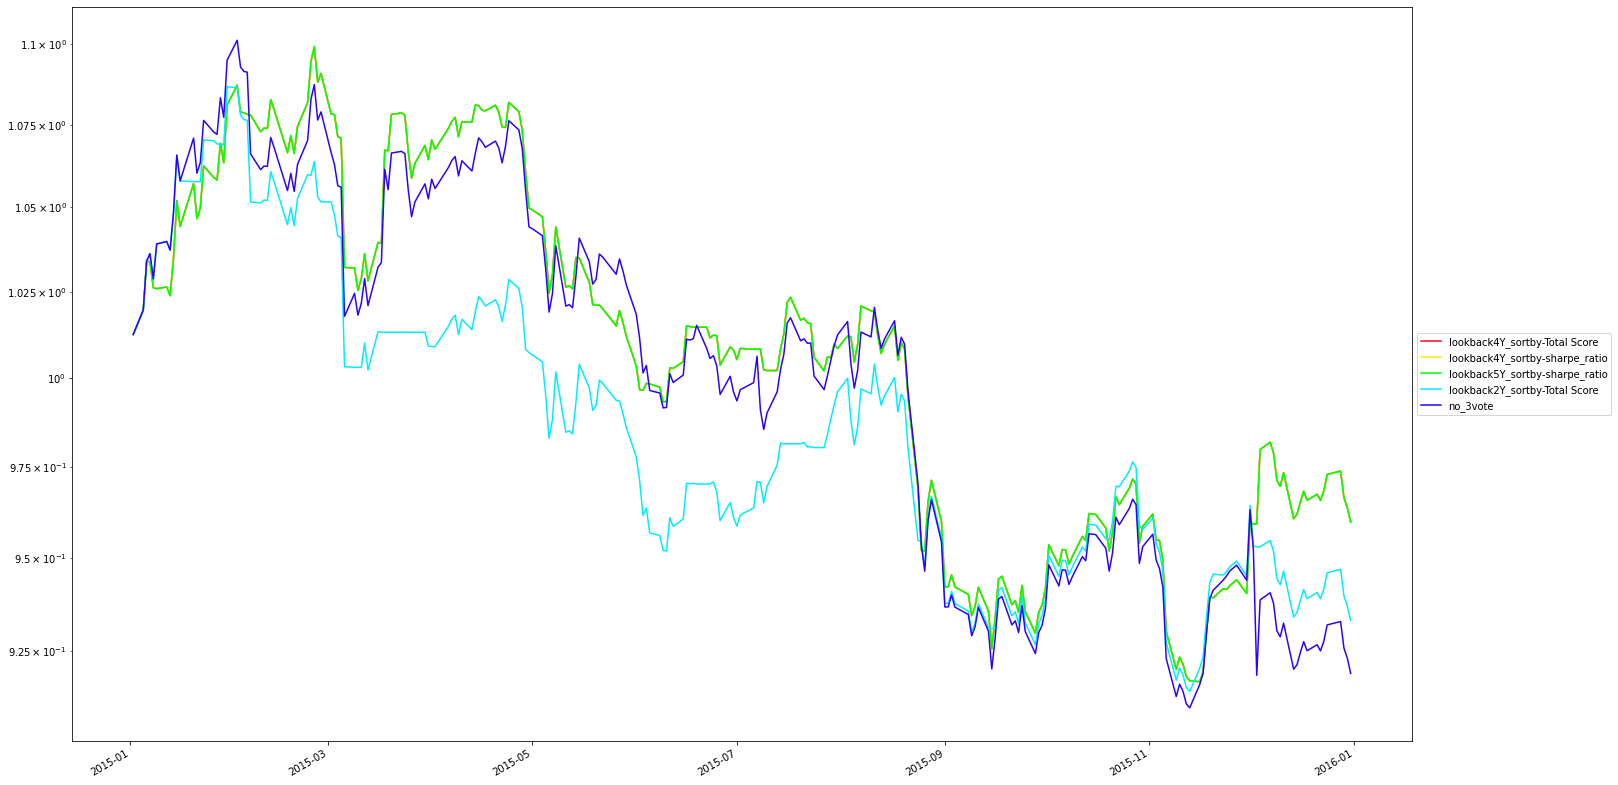

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       0.124161       0.124161      1.198291   
lookback4Y_sortby-sharpe_ratio      0.124161       0.124161      1.198291   
lookback5Y_sortby-sharpe_ratio      0.127279       0.127279      1.160750   
lookback2Y_sortby-Total Score       0.127991       0.127991      1.130888   
no_3vote                            0.119003       0.119003      0.976945   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.102019     -0.090590     -0.029084   
lookback4Y_sortby-sharpe_ratio           0.102019     -0.090590     -0.029084   
lookback5Y_sortby-sharpe_ratio           0.108261     -0.075795     -0.021389   
lookback2Y_sortby-Total Score            0.112050     -0.080533     -0.027036   
no_3vote                                 0.122800     -0.111983     -0.031354   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score       1.370591      4.269100   0.817460   
lookback4Y_sortby-sharpe_ratio      1.370591      4.269100   0.817460   
lookback5Y_sortby-sharpe_ratio      1.679246      5.950737   0.972222   
lookback2Y_sortby-Total Score       1.589299      4.734068   0.853175   
no_3vote                            1.062688      3.795484   1.000000   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score     0.087649    119.829136    106.208070   
lookback4Y_sortby-sharpe_ratio    0.087649    119.829136    106.208070   
lookback5Y_sortby-sharpe_ratio    0.039841    116.074992    106.363927   
lookback2Y_sortby-Total Score     0.039841    113.088829    106.399533   
no_3vote                          0.000000     97.694539    105.950139   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      90.941030     6.159315  
lookback4Y_sortby-sharpe_ratio     90.941030     6.159315  
lookback5Y_sortby-sharpe_ratio     92.420494     6.061167  
lookback2Y_sortby-Total Score      91.946724     5.891731  
no_3vote                           88.801724     4.919827

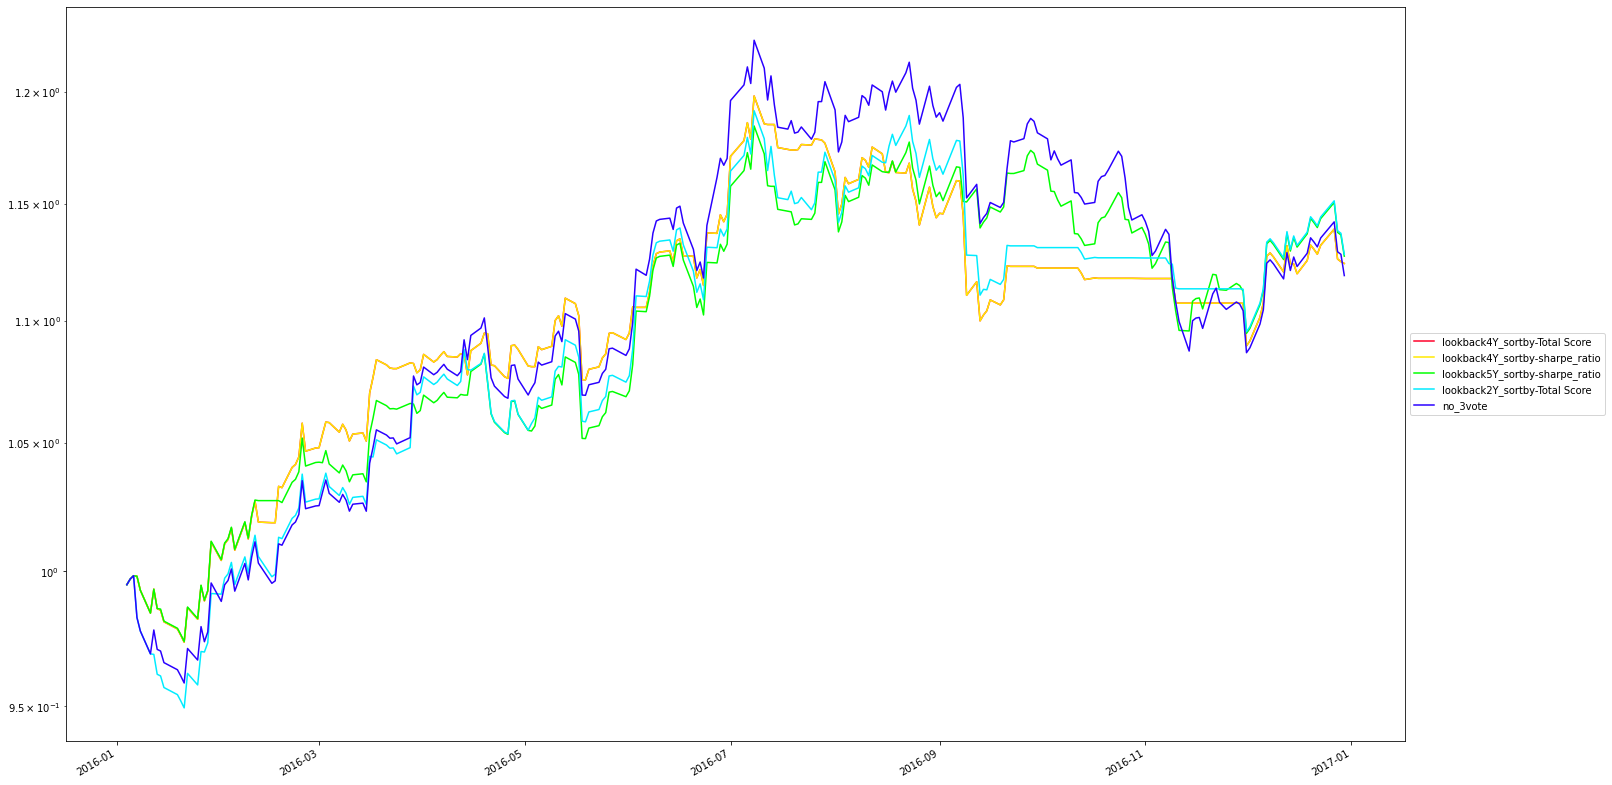

total_return  annual_return  sharpe_ratio  \
no_3vote                            0.234198       0.235233      1.844922   
lookback5Y_sortby-sharpe_ratio      0.176398       0.177159      1.685533   
lookback4Y_sortby-Total Score       0.135207       0.135781      1.228665   
lookback4Y_sortby-sharpe_ratio      0.135207       0.135781      1.228665   
lookback2Y_sortby-Total Score       0.123216       0.123736      1.177162   

                                annual_volatility  max_drawdown  avg_drawdown  \
no_3vote                                 0.118343     -0.060574     -0.014130   
lookback5Y_sortby-sharpe_ratio           0.099738     -0.054622     -0.014044   
lookback4Y_sortby-Total Score            0.108424     -0.064264     -0.020342   
lookback4Y_sortby-sharpe_ratio           0.108424     -0.064264     -0.020342   
lookback2Y_sortby-Total Score            0.103677     -0.066659     -0.015224   

                                return/maxdd  return/avgdd  buy_ratio  \
no_3vote                            3.883398     16.647974   1.000000   
lookback5Y_sortby-sharpe_ratio      3.243357     12.614335   0.908367   
lookback4Y_sortby-Total Score       2.112852      6.675017   0.932271   
lookback4Y_sortby-sharpe_ratio      2.112852      6.675017   0.932271   
lookback2Y_sortby-Total Score       1.856248      8.127943   0.908367   

                                flip_ratio  Sharpe Score  Return Score  \
no_3vote                             0.000    184.492161    111.761651   
lookback5Y_sortby-sharpe_ratio       0.072    168.553319    108.857967   
lookback4Y_sortby-Total Score        0.024    122.866455    106.789035   
lookback4Y_sortby-sharpe_ratio       0.024    122.866455    106.789035   
lookback2Y_sortby-Total Score        0.056    117.716193    106.186821   

                                Max-DD Score  Total Score  
no_3vote                           93.942599    10.097903  
lookback5Y_sortby-sharpe_ratio     94.537778     9.040352  
lookback4Y_sortby-Total Score      93.573581     6.500905  
lookback4Y_sortby-sharpe_ratio     93.573581     6.500905  
lookback2Y_sortby-Total Score      93.334056     6.171195

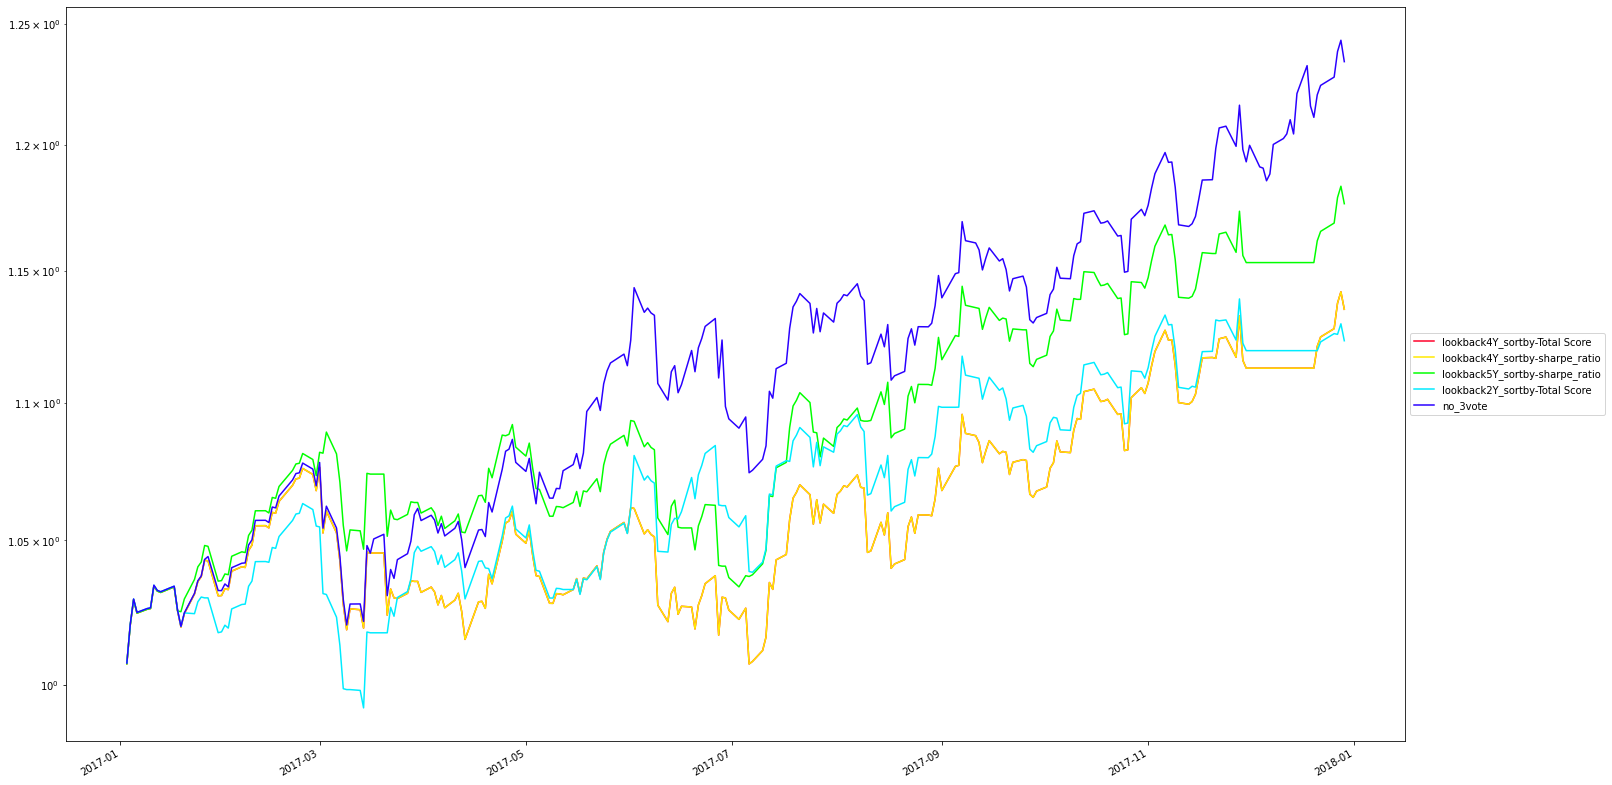

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score      -0.088860      -0.089198     -0.677587   
lookback4Y_sortby-sharpe_ratio     -0.088860      -0.089198     -0.677587   
lookback5Y_sortby-sharpe_ratio     -0.088860      -0.089198     -0.677587   
lookback2Y_sortby-Total Score      -0.121683      -0.122137     -0.857292   
no_3vote                           -0.130142      -0.130625     -0.892933   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.126096     -0.167843     -0.081626   
lookback4Y_sortby-sharpe_ratio           0.126096     -0.167843     -0.081626   
lookback5Y_sortby-sharpe_ratio           0.126096     -0.167843     -0.081626   
lookback2Y_sortby-Total Score            0.140380     -0.204366     -0.104392   
no_3vote                                 0.144927     -0.222995     -0.127863   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score      -0.531434     -1.092756   0.952191   
lookback4Y_sortby-sharpe_ratio     -0.531434     -1.092756   0.952191   
lookback5Y_sortby-sharpe_ratio     -0.531434     -1.092756   0.952191   
lookback2Y_sortby-Total Score      -0.597639     -1.169985   0.992032   
no_3vote                           -0.585773     -1.021602   1.000000   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score        0.080             0     95.540124   
lookback4Y_sortby-sharpe_ratio       0.080             0     95.540124   
lookback5Y_sortby-sharpe_ratio       0.080             0     95.540124   
lookback2Y_sortby-Total Score        0.016             0     93.893158   
no_3vote                             0.000             0     93.468765   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      83.215677    -4.673141  
lookback4Y_sortby-sharpe_ratio     83.215677    -4.673141  
lookback5Y_sortby-sharpe_ratio     83.215677    -4.673141  
lookback2Y_sortby-Total Score      79.563448    -5.918971  
no_3vote                           77.700450    -6.232768

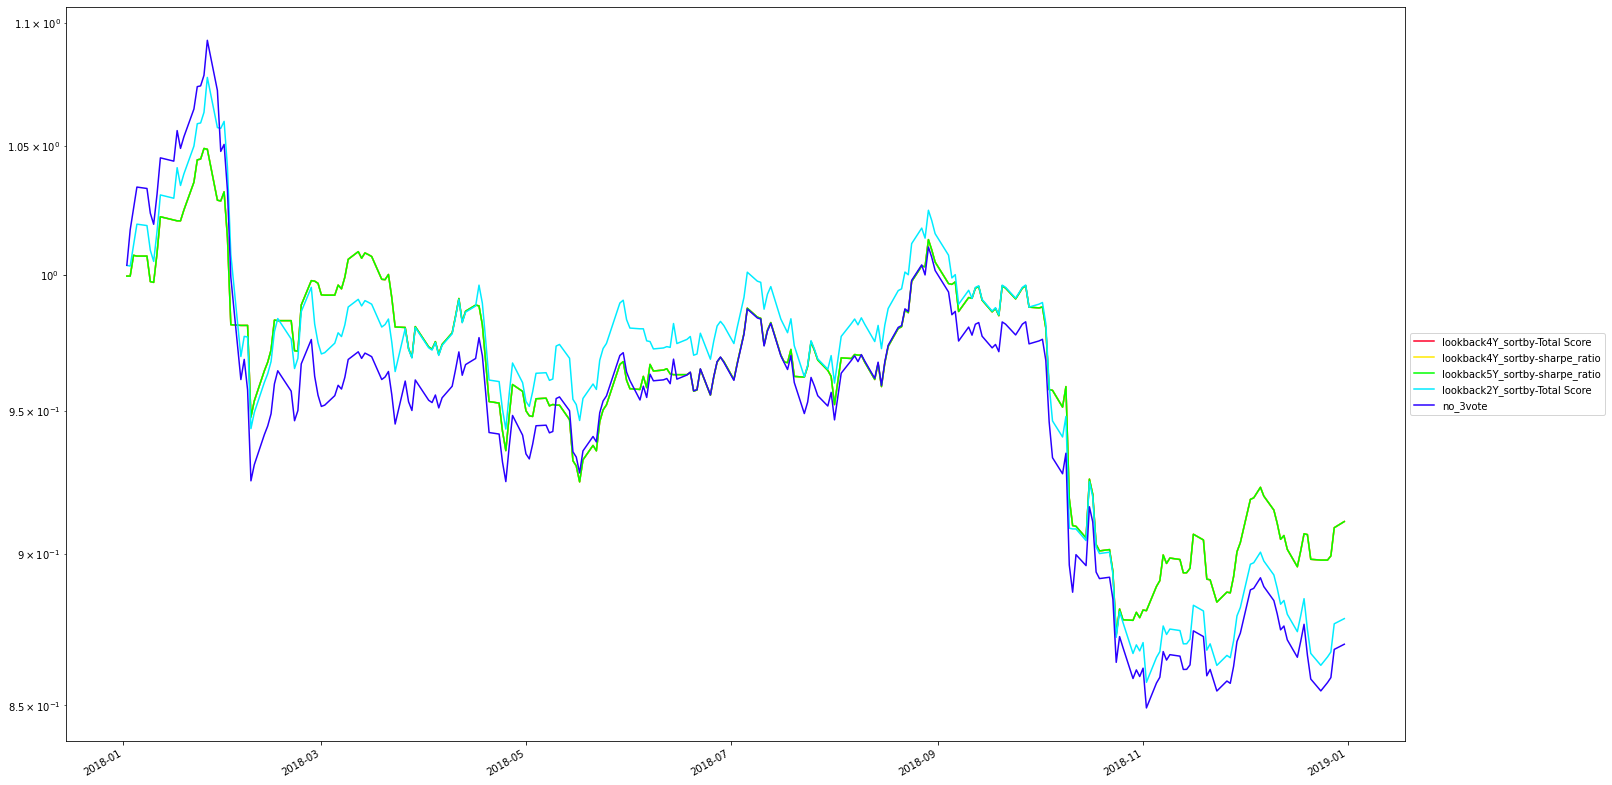

total_return  annual_return  sharpe_ratio  \
lookback2Y_sortby-Total Score       0.332579       0.332579      2.559258   
no_3vote                            0.351095       0.351095      2.459395   
lookback4Y_sortby-Total Score       0.296177       0.296177      2.232531   
lookback4Y_sortby-sharpe_ratio      0.296177       0.296177      2.232531   
lookback5Y_sortby-sharpe_ratio      0.264789       0.264789      2.039651   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback2Y_sortby-Total Score            0.114816     -0.065508     -0.018404   
no_3vote                                 0.125624     -0.051888     -0.015750   
lookback4Y_sortby-Total Score            0.119444     -0.058016     -0.018725   
lookback4Y_sortby-sharpe_ratio           0.119444     -0.058016     -0.018725   
lookback5Y_sortby-sharpe_ratio           0.118664     -0.053666     -0.017434   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback2Y_sortby-Total Score       5.076880     18.071408   0.988095   
no_3vote                            6.766409     22.292273   1.000000   
lookback4Y_sortby-Total Score       5.105087     15.817283   0.968254   
lookback4Y_sortby-sharpe_ratio      5.105087     15.817283   0.968254   
lookback5Y_sortby-sharpe_ratio      4.934054     15.188238   0.988095   

                                flip_ratio  Sharpe Score  Return Score  \
lookback2Y_sortby-Total Score     0.023904    255.925833    116.628929   
no_3vote                          0.000000    245.939512    117.554733   
lookback4Y_sortby-Total Score     0.023904    223.253141    114.808848   
lookback4Y_sortby-sharpe_ratio    0.023904    223.253141    114.808848   
lookback5Y_sortby-sharpe_ratio    0.007968    203.965141    113.239455   

                                Max-DD Score  Total Score  
lookback2Y_sortby-Total Score      93.449155    14.131642  
no_3vote                           94.811211    13.793009  
lookback4Y_sortby-Total Score      94.198395    12.353462  
lookback4Y_sortby-sharpe_ratio     94.198395    12.353462  
lookback5Y_sortby-sharpe_ratio     94.633438    11.253874

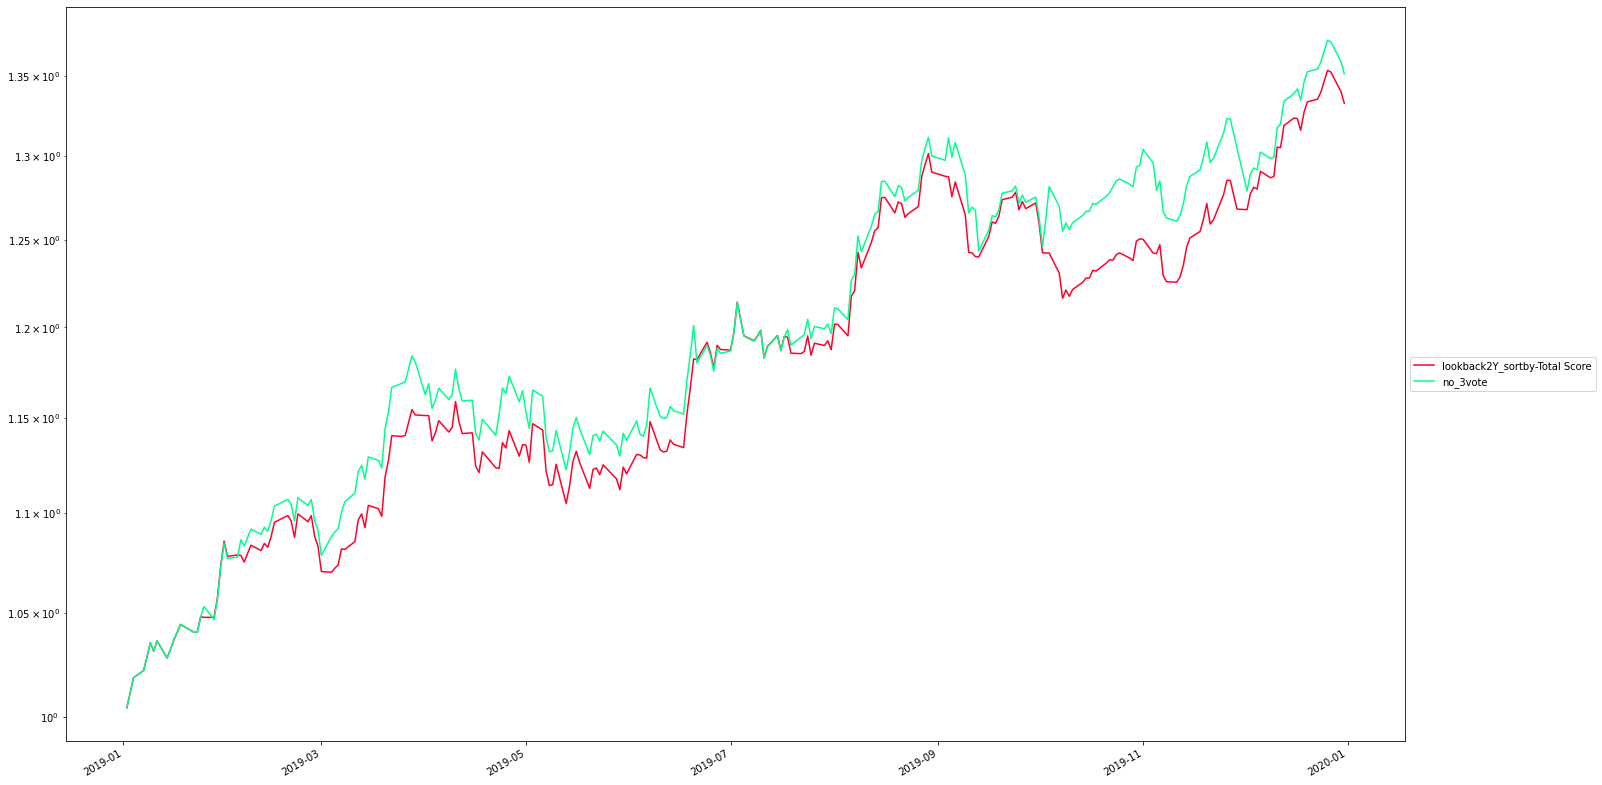

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       0.247443       0.246353      1.682640   
lookback4Y_sortby-sharpe_ratio      0.247443       0.246353      1.682640   
lookback2Y_sortby-Total Score       0.204024       0.203141      1.369184   
no_3vote                            0.159167       0.158490      1.026049   
lookback5Y_sortby-sharpe_ratio      0.147052       0.146430      0.965284   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.136466     -0.122833     -0.030124   
lookback4Y_sortby-sharpe_ratio           0.136466     -0.122833     -0.030124   
lookback2Y_sortby-Total Score            0.142498     -0.108889     -0.032354   
no_3vote                                 0.155117     -0.148309     -0.043135   
lookback5Y_sortby-sharpe_ratio           0.153829     -0.139548     -0.040558   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score       2.005603      8.177991   0.988142   
lookback4Y_sortby-sharpe_ratio      2.005603      8.177991   0.988142   
lookback2Y_sortby-Total Score       1.865574      6.278609   0.984190   
no_3vote                            1.068647      3.674292   1.000000   
lookback5Y_sortby-sharpe_ratio      1.049314      3.610420   0.996047   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score     0.023810    168.264022    112.317669   
lookback4Y_sortby-sharpe_ratio    0.023810    168.264022    112.317669   
lookback2Y_sortby-Total Score     0.023810    136.918368    110.157039   
no_3vote                          0.000000    102.604935    107.924514   
lookback5Y_sortby-sharpe_ratio    0.007937     96.528399    107.321496   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      87.716743     9.030805  
lookback4Y_sortby-sharpe_ratio     87.716743     9.030805  
lookback2Y_sortby-Total Score      89.111085     7.317177  
no_3vote                           85.169077     5.181152  
lookback5Y_sortby-sharpe_ratio     86.045179     4.860828

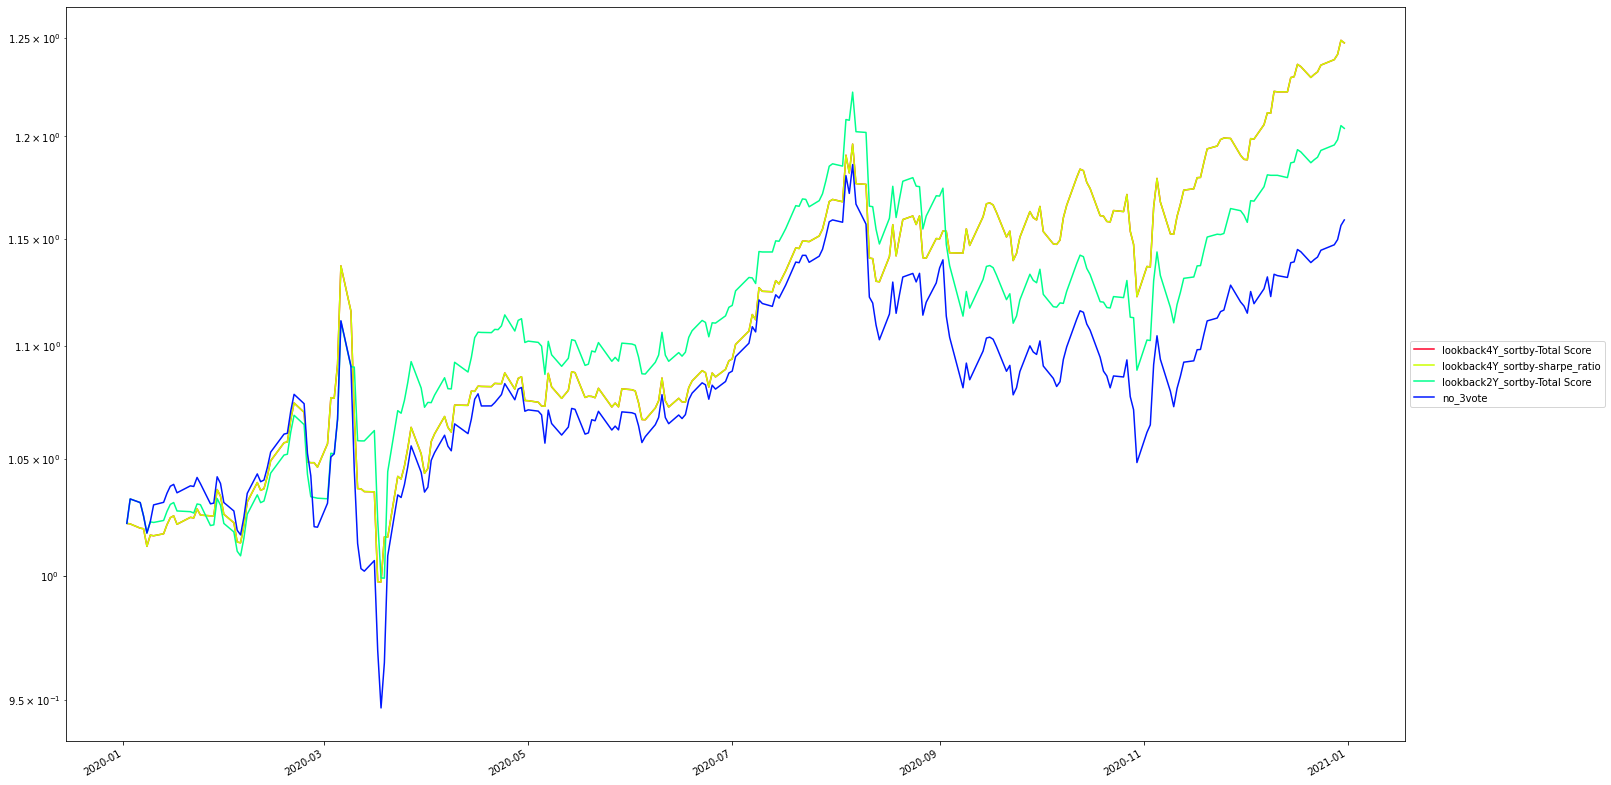

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score       0.187187       0.187187      1.455681   
lookback5Y_sortby-sharpe_ratio      0.168015       0.168015      1.322861   
lookback4Y_sortby-sharpe_ratio      0.163193       0.163193      1.287705   
no_3vote                            0.172162       0.172162      1.261406   
lookback2Y_sortby-Total Score       0.156978       0.156978      1.251170   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.123110     -0.070172     -0.022635   
lookback5Y_sortby-sharpe_ratio           0.123161     -0.071609     -0.023328   
lookback4Y_sortby-sharpe_ratio           0.123324     -0.071609     -0.023515   
no_3vote                                 0.132966     -0.076922     -0.024919   
lookback2Y_sortby-Total Score            0.122566     -0.071609     -0.024013   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score       2.667539      8.269853   0.976190   
lookback5Y_sortby-sharpe_ratio      2.346295      7.202313   0.988095   
lookback4Y_sortby-sharpe_ratio      2.278950      6.939978   0.980159   
no_3vote                            2.238143      6.908753   1.000000   
lookback2Y_sortby-Total Score       2.192158      6.537076   0.964286   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score     0.047809    145.568099    109.359368   
lookback5Y_sortby-sharpe_ratio    0.023904    132.286141    108.400762   
lookback4Y_sortby-sharpe_ratio    0.039841    128.770499    108.159635   
no_3vote                          0.000000    126.140601    108.608124   
lookback2Y_sortby-Total Score     0.055777    125.116984    107.848883   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      92.982771     7.863480  
lookback5Y_sortby-sharpe_ratio     92.839126     7.096340  
lookback4Y_sortby-sharpe_ratio     92.839126     6.896445  
no_3vote                           92.307799     6.783232  
lookback2Y_sortby-Total Score      92.839126     6.682694

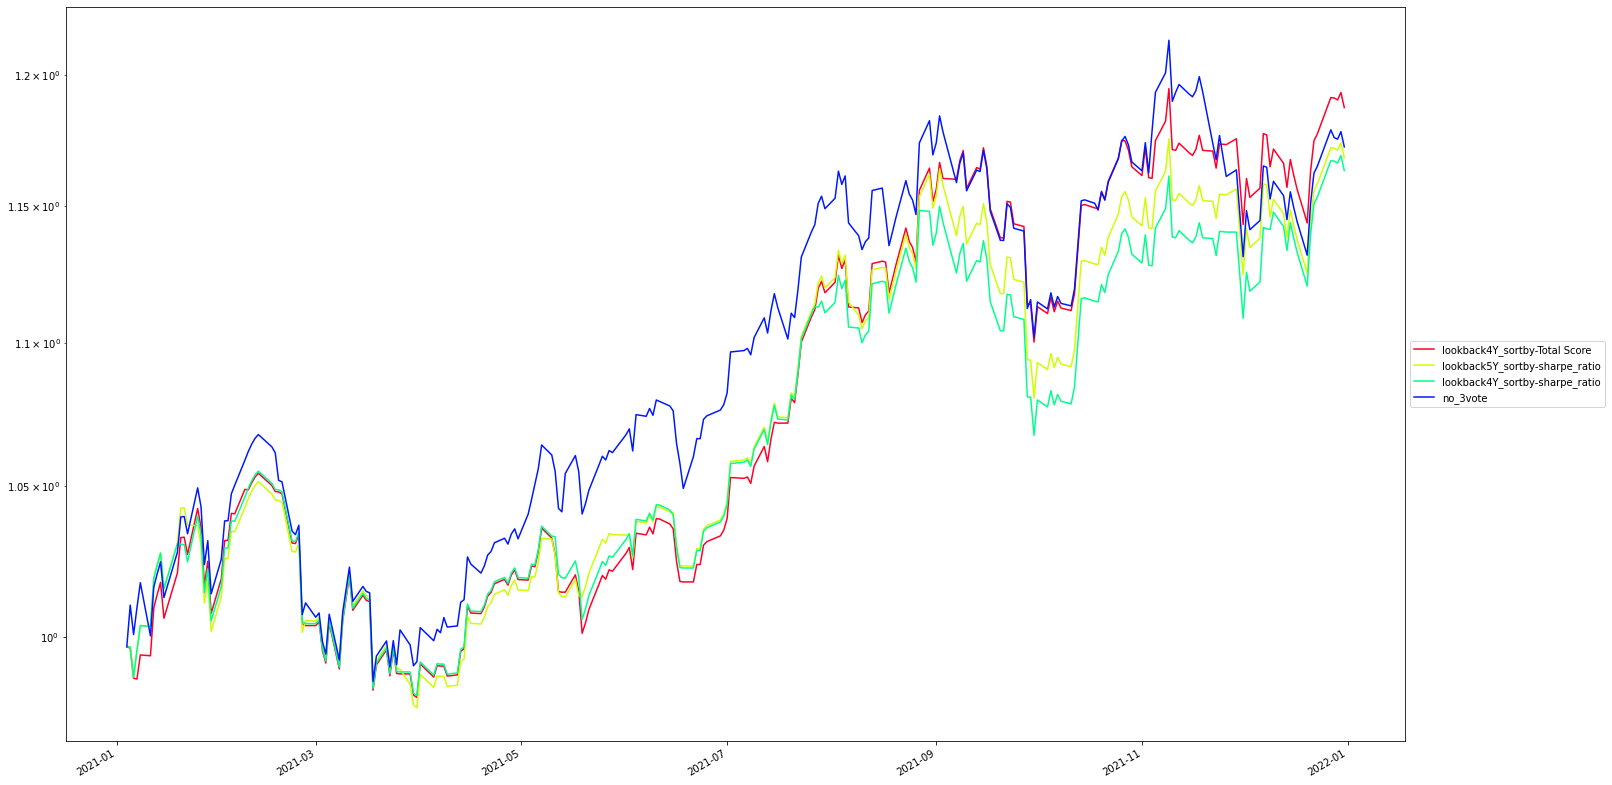

total_return  annual_return  sharpe_ratio  \
lookback4Y_sortby-Total Score      -0.063805      -0.108973     -0.739236   
lookback4Y_sortby-sharpe_ratio     -0.063805      -0.108973     -0.739236   
no_3vote                           -0.074110      -0.126065     -0.849847   
lookback5Y_sortby-sharpe_ratio     -0.083010      -0.140714     -1.163191   
lookback2Y_sortby-Total Score      -0.128115      -0.213309     -1.924969   

                                annual_volatility  max_drawdown  avg_drawdown  \
lookback4Y_sortby-Total Score            0.142391     -0.128456     -0.068549   
lookback4Y_sortby-sharpe_ratio           0.142391     -0.128456     -0.068549   
no_3vote                                 0.146027     -0.145694     -0.075928   
lookback5Y_sortby-sharpe_ratio           0.123792     -0.125167     -0.069548   
lookback2Y_sortby-Total Score            0.120807     -0.164265     -0.099091   

                                return/maxdd  return/avgdd  buy_ratio  \
lookback4Y_sortby-Total Score      -0.848331     -1.589722   1.000000   
lookback4Y_sortby-sharpe_ratio     -0.848331     -1.589722   1.000000   
no_3vote                           -0.865274     -1.660340   1.000000   
lookback5Y_sortby-sharpe_ratio     -1.124203     -2.023264   0.979167   
lookback2Y_sortby-Total Score      -1.298571     -2.152653   0.972222   

                                flip_ratio  Sharpe Score  Return Score  \
lookback4Y_sortby-Total Score     0.000000             0     94.551340   
lookback4Y_sortby-sharpe_ratio    0.000000             0     94.551340   
no_3vote                          0.000000             0     93.696727   
lookback5Y_sortby-sharpe_ratio    0.041958             0     92.964321   
lookback2Y_sortby-Total Score     0.055944             0     89.334536   

                                Max-DD Score  Total Score  
lookback4Y_sortby-Total Score      87.154393    -4.883325  
lookback4Y_sortby-sharpe_ratio     87.154393    -4.883325  
no_3vote                           85.430574    -5.608033  
lookback5Y_sortby-sharpe_ratio     87.483254    -7.145361  
lookback2Y_sortby-Total Score      83.573544   -11.512715

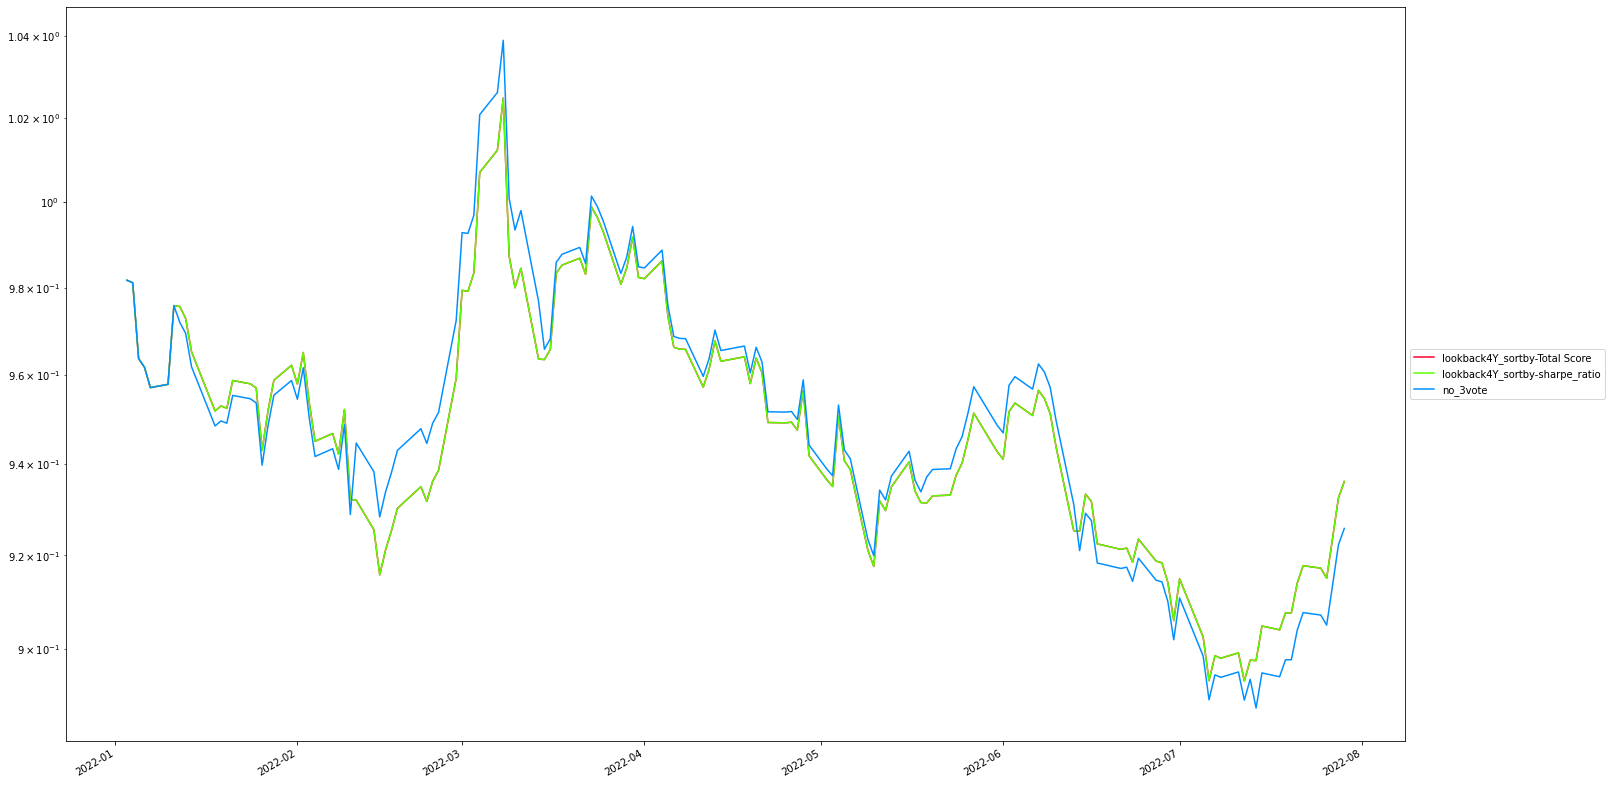

In [106]:
best_ret_cases_08_22 = ret_cases[met_08_22_best.index]
for y in range(2008, 2023):
    met_tmp = empy_metric(best_ret_cases_08_22[str(y)])
    met_tmp = calculation_score(met_tmp)
    met_tmp = met_tmp.sort_values('sharpe_ratio', ascending=False)#[:'no_3vote']
    display(met_tmp)
    if len(met_tmp[:'no_3vote']) == 1:
        show_cum_ret(best_ret_cases_08_22[str(y)])
    else:
        show_cum_ret(best_ret_cases_08_22[str(y)][met_tmp[:'no_3vote'].index])

In [ ]:
# split every 5 years

In [ ]:
tmp = ret_vote0['2008':'2012']
print(tmp.index[0], tmp.index[-1])
met = empy_metric(tmp)
met.to_csv('./result/2022/cashON_signal/metrics/2008-2012.csv')

tmp = ret_vote0['2013':'2022']
print(tmp.index[0], tmp.index[-1])
met = empy_metric(tmp)
met.to_csv('./result/2022/cashON_signal/metrics/2013-2022.csv')


In [ ]:
tmp = ret_vote0['2013':'2017']
print(tmp.index[0], tmp.index[-1])
met = empy_metric(tmp)
met.to_csv('./result/2022/cashON_signal/metrics/2013-2017.csv')

tmp = ret_vote0['2018':'2022']
print(tmp.index[0], tmp.index[-1])
met = empy_metric(tmp)
met.to_csv('./result/2022/cashON_signal/metrics/2017-2022.csv')

In [ ]:
tmp = ret_vote0['2018':'2022']
print(tmp.index[0], tmp.index[-1])
met = empy_metric(tmp)
met.to_csv('./result/2022/cashON_signal/metrics/2018-2022.csv')

In [77]:
met08_12 = pd.read_csv('./result/2022/cashON_signal/metrics/2008-2012.csv', index_col=0)
met13_22 = pd.read_csv('./result/2022/cashON_signal/metrics/2013-2022.csv', index_col=0)
met13_17 = pd.read_csv('./result/2022/cashON_signal/metrics/2013-2017.csv', index_col=0)
met18_22 = pd.read_csv('./result/2022/cashON_signal/metrics/2018-2022.csv', index_col=0)

In [80]:
met08_12 = calculation_score(met08_12)
met13_22 = calculation_score(met13_22)
met13_17 = calculation_score(met13_17)
met18_22 = calculation_score(met18_22)

In [81]:
show_metrics = [
    'Sharpe Score', 'Return Score', 'Max-DD Score', 'Total Score',
    'total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
    'max_drawdown', 'avg_drawdown', 'return/maxdd', 'return/avgdd', 
    'buy_ratio', 'flip_ratio'
]

met08_12_bm = met08_12.loc[['no_3vote'], show_metrics]
met13_22_bm = met13_22.loc[['no_3vote'], show_metrics]
met13_17_bm = met13_17.loc[['no_3vote'], show_metrics]
met18_22_bm = met18_22.loc[['no_3vote'], show_metrics]

In [82]:
sortby = 'Total Score'

In [ ]:
yearly_met = {}
for yy in range(2018, 2023):
    file = './result/metrics/{}.csv'.format(yy)
    if os.path.exists(file):
        met = pd.read_csv(file, index_col=0)
    else:
        print(yy)
        tmp = ret_vote0[str(yy)]
        print(tmp.index[0], tmp.index[-1])
        met = empy_metric(tmp)
        met = calculation_score(met)
        met.to_csv(file)
    yearly_met[yy] = met

In [ ]:
lookback = [1, 2, 3, 4, 5]
lookback_met = {}
for lb in lookback:
    print("====================== lookback ========================= ", lb)
    if lb not in lookback_met.keys():
        lookback_met[lb] = {}

    range_s = 2008 + lb
    for yy in range(range_s, 2023):
        print("====================== for year ========================= ", yy)
        file2 = './result/metrics/lookback{}_{}-{}.csv'.format(lb, start, end)
        if os.path.exists(file2):
            met = pd.read_csv(file2, index_col=0)
        else:
            try:
                start = yy - lb
                end = yy - 1
                print(start, end)
                if start == end:
                    continue
                tmp = ret_vote0[str(start):str(end)]
                print(tmp.index[0], tmp.index[-1])
                met = empy_metric(tmp)
                met = calculation_score(met)
                met.to_csv(file2)
            except Exception as e:
                print(e)
        lookback_met[lb][yy] = met


In [ ]:
better08_12 = met08_12.sort_values(sortby, ascending=False)[:'no_3vote'][show_metrics]
display(better08_12.iloc[:10, :])
display(better08_12.iloc[-1:, :])

In [ ]:
display(met13_22.sort_values(sortby, ascending=False)[:10][show_metrics])
display(met13_22_bm)

In [ ]:
better08_12_in13_22 = met13_22.loc[list(better08_12.index[:10]) + ['no_3vote'], show_metrics]
better08_12_in13_22.sort_values(sortby, ascending=False)[:'no_3vote'][show_metrics]

In [ ]:
display(met13_17.sort_values(sortby, ascending=False)[:10][show_metrics])
display(met13_17_bm)

In [ ]:
better08_12_in13_17 = met13_17.loc[list(better08_12.index[:10]) + ['no_3vote'], show_metrics]
better08_12_in13_17.sort_values(sortby, ascending=False)[:'no_3vote'][show_metrics]

In [ ]:
better13_17 = met13_17.sort_values(sortby, ascending=False)[:10][show_metrics]
display(better13_17)
display(met13_17_bm)

In [ ]:
better08_12_in13_17 = met13_17.loc[list(better08_12.index[:10]) + ['no_3vote'], show_metrics]
better08_12_in13_17.sort_values(sortby, ascending=False)[:'no_3vote'][show_metrics]

In [ ]:
display(met18_22.sort_values(sortby, ascending=False)[:10][show_metrics])
display(met18_22_bm)

In [ ]:
better08_12_in18_22 = met18_22.loc[list(better08_12.index[:10]) + ['no_3vote'], show_metrics]
better08_12_in18_22.sort_values(sortby, ascending=False)[:'no_3vote'][show_metrics]

In [ ]:
better13_17_in18_22 = met18_22.loc[list(better13_17.index[:10]) + ['no_3vote'], show_metrics]
better13_17_in18_22.sort_values(sortby, ascending=False)[:'no_3vote'][show_metrics]

In [ ]:
# preds_csv = [
#     ('./data/data_price/data_price_xxz.csv', [0], ['xxz'], [1, 5, 10, 21]),
#     ('./data/data_price/data_price_xzz.csv', [0], ['xzz'], [1, 5, 10, 21]),
#     ('./data/data_price/data_price(13ETFs).csv', None, None, [1, 5, 10, 21])
# ]

preds_csv = [
    ('./data/data_price/data_price_xxz.csv', [0], ['xxz'], [1]),
    ('./data/data_price/data_price_xzz.csv', [0], ['xzz'], [1]),
    ('./data/data_price/data_price(13ETFs).csv', None, None, [1])
]


preds = pd.DataFrame()
rets = pd.DataFrame()
for f, col, col_name, pps in preds_csv:
    print(f, col, col_name, pps)
    df = pd.read_csv(f, index_col=0)
    df.index = pd.to_datetime(df.index)
    if col is not None:
        df = df.iloc[:, col]
        df.columns = col_name

    for pp in pps:
        df_pct = df.pct_change(pp)
        df_pct.columns = ["{}_pp{}".format(c, pp) for c in df_pct.columns]
        rets = pd.concat([rets, df_pct], axis=1)
        df_pct = (df_pct>=0).astype(int)
        preds = pd.concat([preds, df_pct], axis=1)

preds = preds.dropna()
rets = rets.dropna()
display(preds.columns)
preds

In [ ]:
rets

In [ ]:
client_ret_df = pd.concat(client_ret.values(), keys=client_ret.keys(), axis=1)
client_ret_df

In [ ]:
cum_returns = empy.cum_returns(client_ret_df)
cum_returns.plot(figsize=(20, 10), title='cum_returns').legend(bbox_to_anchor=(1.1, 1.05))
client_ret_df.index = pd.to_datetime(client_ret_df.index)

for client in client_ret_df.columns:
    # ax = client_ret_df[client].plot.bar(figsize=(20, 10), title='daily return')
    # for i, t in enumerate(ax.get_xticklabels()):
    #     if (i % 252*3) != 0:
    #         t.set_visible(False)
    # ax.legend(bbox_to_anchor=(1.1, 1.05))


    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    fig.suptitle(client)

    ax.bar(client_ret_df[client].index, client_ret_df[client].values, label=client)
    ax.set_ylabel('daily return')
    ax.legend(bbox_to_anchor=(1.1, 1.05))


In [ ]:
asset_daily_ret = rets.loc[:, (rets.columns.str.endswith('_pp1')) & ~((rets.columns.str.startswith('xxz_')) | (rets.columns.str.startswith('xzz_')))]
asset_daily_ret

In [8]:
## sliding correlation 13 assets
lookback = [10, 15, 20, 50] 

corr_dict = {}
corr_avg = pd.DataFrame()
corr_avg_abs = pd.DataFrame()
corr_std = pd.DataFrame()
corr_std_abs = pd.DataFrame()
for lb in lookback:
    asset_daily_corr = asset_daily_ret.rolling(lb).corr().dropna()
    corr_dict[lb] = asset_daily_corr

    asset_daily_corr_avg = asset_daily_corr.groupby(level=0).apply(lambda x: x.values.mean())
    # display(asset_daily_corr_avg)
    corr_avg[lb] = asset_daily_corr_avg

    asset_daily_corr_avg_abs = asset_daily_corr.groupby(level=0).apply(lambda x: x.abs().values.mean())
    # display(asset_daily_corr_avg_abs)
    corr_avg_abs[lb] = asset_daily_corr_avg_abs

    asset_daily_corr_std = asset_daily_corr.groupby(level=0).apply(lambda x: x.values.std())
    # display(asset_daily_corr_std)
    corr_std[lb] = asset_daily_corr_std

    asset_daily_corr_std_abs = asset_daily_corr.groupby(level=0).apply(lambda x: x.abs().values.std())
    # display(asset_daily_corr_std_abs)
    corr_std_abs[lb] = asset_daily_corr_std_abs


In [11]:
# 
corr_map = {
    # 'corr_dict': corr_dict,
    'corr_avg': corr_avg,
    'corr_avg_abs': corr_avg_abs,
    'corr_std': corr_std,
    'corr_std_abs': corr_std_abs,

    'corr_avg_pct': corr_avg.pct_change().dropna(),
    'corr_avg_abs_pct': corr_avg_abs.pct_change().dropna(),
    'corr_std_pct': corr_std.pct_change().dropna(),
    'corr_std_abs_pct': corr_std_abs.pct_change().dropna()
}

In [ ]:
    
# for lb in lookback:
if True:
    ## histogram
    corr_avg.hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10), density = True)
    plt.suptitle('{} corr_avg histogram'.format(lb))
    # plt.show()
    # plt.clf()
    
    corr_avg_abs.hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10))
    plt.suptitle('{} corr_avg_abs histogram'.format(lb))
    # plt.show()
    # plt.clf()
    
    corr_std.hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10))
    plt.suptitle('{} corr_std histogram'.format(lb))
    # plt.show()
    # plt.clf()
    
    corr_std_abs.hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10))
    plt.suptitle('{} corr_std_abs histogram'.format(lb))
    plt.show()
    plt.clf()

    ## pct_change
    # corr_avg[lb].pct_change().plot(figsize=(20, 10), title='{} corr_avg pct_change'.format(lb)).legend(bbox_to_anchor=(1.1, 1.05))
    # # plt.show()
    # # plt.clf()
    # corr_avg_abs[lb].pct_change().plot(figsize=(20, 10), title='{} corr_avg_abs pct_change'.format(lb)).legend(bbox_to_anchor=(1.1, 1.05))
    # # plt.show()
    # # plt.clf()
    # corr_std[lb].pct_change().plot(figsize=(20, 10), title='{} corr_std pct_change'.format(lb)).legend(bbox_to_anchor=(1.1, 1.05))
    # # plt.show()
    # # plt.clf()
    # corr_std_abs[lb].pct_change().plot(figsize=(20, 10), title='{} corr_std_abs pct_change'.format(lb)).legend(bbox_to_anchor=(1.1, 1.05))
    # plt.show()
    # plt.clf()

    ## histogram
    
    corr_avg.pct_change().hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10))
    plt.suptitle('{} corr_avg pct_change histogram'.format(lb))
    # plt.show()
    # plt.clf()
    
    corr_avg_abs.pct_change().hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10))
    plt.suptitle('{} corr_avg_abs pct_change histogram'.format(lb))
    # plt.show()
    # plt.clf()
    
    corr_std.pct_change().hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10))
    plt.suptitle('{} corr_std pct_change histogram'.format(lb))
    # plt.show()
    # plt.clf()
    
    corr_std_abs.pct_change().hist(grid=True, bins=20, rwidth=0.9, figsize=(20, 10))
    plt.suptitle('{} corr_std_abs pct_change histogram'.format(lb))
    plt.show()
    plt.clf()

In [ ]:
th_lookback = [1, 2, 3] # year

for th_lb in th_lookback:
    for year in range(2008, 2023):
        start_y = year - th_lb
        display(start_y)
        end_y = year - 1
        display(end_y)

        for metrics, metrics_df in corr_map.items():
            for col in metrics_df.columns:
                if start_y == end_y:
                    df = metrics_df[col][str(start_y)]
                else:
                    df = metrics_df[col][str(start_y):str(end_y)]
                cut_df = pd.cut(df, 10)
                # display(vars(cut_df))
                bin_ratio = (cut_df.value_counts()/cut_df.value_counts().sum()).sort_index()
                display(bin_ratio)
                # display(cats)
                # display(bins)
                break
            break
        break
    break

In [16]:
threshold_gt = {
    'corr_avg': {10: [0.5, 0.6], 15: [0.5, 0.6], 20: [0.5, 0.6], 50: [0.45, 0.5]},
    'corr_avg_abs': {10: [0.7, 0.75], 15: [0.65, 0.7], 20: [0.65, 0.7], 50: [0.6, 0.65]},
    'corr_std': {10: [0.7, 0.75], 15: [0.65, 0.7], 20: [0.65, 0.7], 50: [0.6, 0.65]},
    'corr_std_abs': {10: [0.35], 15: [0.35], 20: [0.35], 50: [0.35]},

    'corr_avg_pct': {10: [0.5, 0.75], 15: [0.25, 0.5], 20: [0.2, 0.4], 50: [0.1]},
    'corr_avg_abs_pct': {10: [0.1, 0.2], 15: [0.1, 0.2], 20: [0.05, 0.1], 50: [0.025, 0.05]},
    'corr_std_pct': {10: [0.25], 15: [0.1, 0.2], 20: [0.1, 0.2], 50: [0.05, 0.1]},
    'corr_std_abs_pct': {10: [0.1, 0.2, 0.4], 15: [0.1, 0.2, 0.4], 20: [0.1, 0.2], 50: [0.05, 0.025]},
}


threshold_lt = {
    'corr_avg': {10: [0.1, 0.2], 15: [0.1, 0.2], 20: [0.1, 0.2], 50: [0.2, 0.25]},
    'corr_avg_abs': {10: [0.35, 0.4], 15: [0.35, 0.4], 20: [0.35, 0.4], 50: [0.35, 0.4]},
    'corr_std': {10: [0.2, 0.3], 15: [0.2, 0.3], 20: [0.2, 0.3], 50: [0.2, 0.3]},
    'corr_std_abs': {10: [0.2, 0.25], 15: [0.2, 0.25], 20: [0.225, 0.25], 50: [0.24, 0.26]},

    'corr_avg_pct': {10: [-0.5, -0.25], 15: [-0.5, -0.25], 20: [-0.2, -0.1], 50: [-0.1]},
    'corr_avg_abs_pct': {10: [-0.2, -0.1], 15: [-0.2, -0.1], 20: [-0.1, -0.05], 50: [-0.05, -0.025]},
    'corr_std_pct': {10: [-0.25, ], 15: [-0.2], 20: [-0.1], 50: [-0.05]},
    'corr_std_abs_pct': {10: [-0.2, -0.1], 15: [-0.2, -0.1], 20: [-0.1, -0.05], 50: [-0.05]},
}

In [ ]:
vote_cases = pd.DataFrame()

for metrics in threshold_gt.keys():
    display(metrics)
    metrics_gt = threshold_gt[metrics]
    metrics_lt = threshold_lt[metrics]

    metrics_df = corr_map[metrics]

    for lb in lookback:
        lb_corr = metrics_df[lb]
        # display(lb_corr.tail(10))
        gt = metrics_gt[lb]
        display("gt", gt)
        for g in gt:
            name = "{}__lb{}__>{}".format(metrics, lb, g)
            vote_cases[name] = (lb_corr<=g).astype(int)

        lt = metrics_lt[lb]
        display("lt", lt)
        for l in lt:
            name = "{}__lb{}__<{}".format(metrics, lb, l)
            vote_cases[name] = (lb_corr>=l).astype(int)
        
        bt = list(itertools.product(lt, gt))
        display("bt", bt)
        for bb in bt:
            if bb[0] == bb[1]:
                continue
            name = "{}__lb{}__out-of{}&{}".format(metrics, lb, min(bb), max(bb))
            vote_cases[name] = ((lb_corr>=min(bb))&(lb_corr<=max(bb))).astype(int)

        # display(vote_cases.tail(10))
vote_cases

In [44]:
vote_cases.to_csv('./result/2022/cashON_signal/corr_threshold_v1.csv')

In [ ]:
vote_cases_original = pd.read_csv('./result/2022/cashON_signal/corr_threshold_v1.csv', index_col=0)
vote_cases_original.index = pd.to_datetime(vote_cases_original.index)
vote_cases_original

In [ ]:
vote_cases_original = vote_cases_original[vote_cases_original['2008':].sum()[(vote_cases_original['2008':].sum()/vote_cases_original['2008':].count())!=1].index]
vote_cases_original

In [ ]:
pairs = list(itertools.combinations(vote_cases_original.columns, 2))
len(pairs)

In [13]:
vote_cases = pd.DataFrame()
exists_case = []
for a, b in pairs:
    # print(a, b)
    if a == b:
        continue

    if (a, b) in exists_case or (b, a) in exists_case:
        continue

    tmp = vote_cases_original[[a, b]].astype(bool)
    # display(tmp)

    name = "({})&({})".format(a, b)
    vote_cases[name] = tmp[a] & tmp[b]

    name = "({})|({})".format(a, b)
    vote_cases[name] = tmp[a] | tmp[b]

    exists_case += [(a, b), (b, a)]
    # display(vote_cases)

    # display(exists_case)

    # if len(vote_cases.columns) >= 4:
    #     break
vote_cases = vote_cases.astype(int)

In [ ]:
display(len(vote_cases))
vote_cases

In [15]:
vote_cases.to_csv('./result/2022/cashON_signal/corr_threshold_v1-combine2condition.csv')

In [ ]:
vote_cases = vote_cases[vote_cases['2008':].sum()[(vote_cases['2008':].sum()/vote_cases['2008':].count())!=1].index]
vote_cases

In [ ]:
vote_down_buy_ratio_list = [0, 0.1, 0.2, 0.3]
vote_down_buy_ratio_df_list = []

for vote_down_buy_ratio in vote_down_buy_ratio_list:
    v = vote_cases.applymap(lambda x: vote_down_buy_ratio if x<0.5 else 1)
    v.columns = v.columns.map(lambda x: x+'___vote_down_buy_{}'.format(vote_down_buy_ratio))
    vote_down_buy_ratio_df_list.append(v)

vote_down_buy_ratio_df = pd.concat(vote_down_buy_ratio_df_list, 1)
vote_down_buy_ratio_df


In [ ]:
vote_down_buy_ratio_df.columns

In [19]:
vote_down_buy_ratio_csv = './result/2022/cashON_signal/vote_down_buy_ratio_corr_threshold_v1-combine2condition.csv'
vote_down_buy_ratio_df.to_csv(vote_down_buy_ratio_csv)